# Coverage Analysis

This notebook analyzes the coverage data from CSV files in the '5xcoverage_csv_files-600-300-3' directory. We will plot coverage over time for all results, grouped by experiment number.

## Import Required Libraries

First, let's import the libraries we'll need for our analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from glob import glob

# Set up the plotting style
plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

## Load and Explore Data

In [2]:
# Define the base directory paths for all three tools
coverup_base_dir = 'data/coverup/scratch/experiment-results'
noplateau_base_dir = 'data/noplateau/scratch/experiment-results'
pynguin_base_dir = 'data/pynguin/scratch/experiment-results'

# Dictionary to map base directories to tool names
tool_dirs = {
    'CoverUp': coverup_base_dir,
    'NoPlateau': noplateau_base_dir,
    'Pynguin': pynguin_base_dir
}

# Get all coverage CSV files from all three tools
csv_files = []
file_metadata = []

def get_module_name(file_path):
    # Read the actual module name from run-info.txt
    path_parts = file_path.split(os.sep)
    base_idx = path_parts.index('experiment-results')
    
    results_dir = os.path.join(*path_parts[:base_idx + 4])  # up to results-* folder
    run_info_path = os.path.join(results_dir, 'run-info.txt')
    
    module_name = path_parts[base_idx + 1]  # fallback to directory name
    if os.path.exists(run_info_path):
        try:
            with open(run_info_path, 'r') as f:
                for line in f:
                    if line.startswith('module-name:'):
                        module_name = line.split(':', 1)[1].strip()
                        break
        except Exception as e:
            print(f"Warning: Could not read module name from {run_info_path}: {e}")
    
    return module_name

# Process each tool's directory
for tool_name, base_dir in tool_dirs.items():
    print(f"\nProcessing {tool_name} from {base_dir}...")
    
    # Use glob to find all coverage_*.csv files in the nested structure
    pattern = os.path.join(base_dir, '*', '*', 'results-*', 'logs', 'coverage_*.csv')
    found_files = glob(pattern)
    
    for file_path in found_files:
        # Extract metadata from the path
        path_parts = file_path.split(os.sep)
        
        # Find the indices of the relevant parts
        try:
            base_idx = path_parts.index('experiment-results')

            module_name = get_module_name(file_path)
            module_run = path_parts[base_idx + 2]
            
            # Extract TOTAL_RUN from results-{TOTAL_RUN}
            results_part = path_parts[base_idx + 3]
            total_run = results_part.replace('results-', '')
            
            csv_files.append(file_path)
            file_metadata.append({
                'file_path': file_path,
                'tool': tool_name,
                'module_name': module_name,
                'module_run': module_run,
                'total_run': total_run,
                'filename': os.path.basename(file_path)
            })
        except (ValueError, IndexError) as e:
            print(f"Could not parse path structure for: {file_path}")

    print(f"Found {len([f for f in csv_files if tool_name in f])} CSV files for {tool_name}")

print(f"\nTotal: Found {len(csv_files)} CSV files across all tools")
print("Example files:", csv_files[:5] if len(csv_files) >= 5 else csv_files)

# Display metadata for first few files from each tool
if file_metadata:
    print("\nFile metadata examples by tool:")
    for tool_name in tool_dirs.keys():
        tool_files = [m for m in file_metadata if m['tool'] == tool_name]
        if tool_files:
            print(f"\n{tool_name.upper()}:")
            for i, metadata in enumerate(tool_files[:2]):
                print(f"  File {i+1}: {metadata}")


Processing CoverUp from data/coverup/scratch/experiment-results...
Found 0 CSV files for CoverUp

Processing NoPlateau from data/noplateau/scratch/experiment-results...
Found 0 CSV files for CoverUp

Processing NoPlateau from data/noplateau/scratch/experiment-results...
Found 0 CSV files for NoPlateau

Processing Pynguin from data/pynguin/scratch/experiment-results...
Found 0 CSV files for NoPlateau

Processing Pynguin from data/pynguin/scratch/experiment-results...
Found 0 CSV files for Pynguin

Total: Found 1947 CSV files across all tools
Example files: ['data/coverup/scratch/experiment-results/flutes/0/results-3/logs/coverage_0.csv', 'data/coverup/scratch/experiment-results/flutes/4/results-23/logs/coverage_4.csv', 'data/coverup/scratch/experiment-results/flutes/6/results-33/logs/coverage_6.csv', 'data/coverup/scratch/experiment-results/flutes/5/results-28/logs/coverage_5.csv', 'data/coverup/scratch/experiment-results/flutes/3/results-18/logs/coverage_3.csv']

File metadata example

In [3]:
# Let's look at the structure of the first file to understand the data
if csv_files:
    df_example = pd.read_csv(csv_files[0])
    print(f"Shape of first file: {df_example.shape}")
    print("Columns:")
    print(df_example.columns.tolist())
    print("\nFirst few rows:")
    display(df_example.head())

Shape of first file: (1, 6)
Columns:
['iteration', 'finish_timestamp', 'finish_total_time_used', 'iteration_type', 'best_coverage', 'coverage']

First few rows:


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage
0,1,17,15,coverup,100,100


## Process All Data Files

Now we'll load all the CSV files and combine them into a single DataFrame, extracting the experiment number and run information from the file names.

In [4]:
def extract_info_from_file_metadata(file_path):
    """Extract experiment info from file metadata"""
    # Find the corresponding metadata for this file
    for metadata in file_metadata:
        if metadata['file_path'] == file_path:
            total_run_num = int(metadata['total_run'])
            module_run_num = int(metadata['module_run'])
            module = metadata['module_name']
            tool = metadata['tool']
            return total_run_num, module_run_num, module, tool
    return None, None, None, None

# Create an empty list to store all dataframes
all_dfs = []

# Process each CSV file
for file in csv_files:
    try:
        # Extract information from filename
        total_run_num, module_run_num, module, tool = extract_info_from_file_metadata(file)
        
        if total_run_num is not None:
            # Read the CSV file
            df = pd.read_csv(file)
            
            # Add metadata columns
            df['total_run_num'] = total_run_num
            df['module_run_num'] = module_run_num
            df['module'] = module
            df['tool'] = tool
            
            # Append to the list of dataframes
            all_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Number of tools: {combined_df['tool'].nunique()}")
    print(f"Tools: {combined_df['tool'].unique()}")
    print(f"Number of modules: {combined_df['module'].nunique()}")
    print(f"Modules: {combined_df['module'].unique()}")
    display(combined_df.head())
else:
    print("No data files were successfully processed")

Combined data shape: (62168, 10)
Number of tools: 3
Tools: ['CoverUp' 'NoPlateau' 'Pynguin']
Number of modules: 23
Modules: ['flutes.math' 'pytutils.env' 'pytutils.excs' 'flutils.pathutils'
 'flutils.decorators' 'isort.io' 'semantic_release.dist'
 'semantic_release.ci_checks' 'flake8.main.debug'
 'flake8.options.aggregator' 'flake8.statistics' 'docstring_parser.google'
 'docstring_parser.numpydoc' 'httpie.utils'
 'httpie.output.formatters.json' 'dataclasses_json.core'
 'dataclasses_json.cfg' 'dataclasses_json.undefined'
 'blib2to3.pgen2.literals' 'py_backwards.conf' 'pypara.commons.others'
 'pymonet.semigroups' 'pypara.accounting.journaling']


,iteration,finish_timestamp,finish_total_time_used,iteration_type,best_coverage,coverage,total_run_num,module_run_num,module,tool
0,1,17,15,coverup,100,100,3,0,flutes.math,CoverUp
1,1,25,24,coverup,100,100,23,4,flutes.math,CoverUp
2,1,16,14,coverup,100,100,33,6,flutes.math,CoverUp
3,1,16,14,coverup,100,100,28,5,flutes.math,CoverUp
4,1,25,24,coverup,100,100,18,3,flutes.math,CoverUp


In [5]:
# Find modules that exist for all tools
tools_set = set(combined_df['tool'].unique())
modules_per_tool = combined_df.groupby('tool')['module'].unique()
modules_all_tools = set.intersection(*(set(mods) for mods in modules_per_tool))

all_modules = set(combined_df['module'].unique())
excluded_modules = all_modules - modules_all_tools

print(f"Modules present in all tools: {len(modules_all_tools)}")
print(sorted(modules_all_tools))
print(f"\nModules excluded (not present in all tools): {len(excluded_modules)}")
print(sorted(excluded_modules))

# Filter combined_df to only keep these modules
combined_df = combined_df[combined_df['module'].isin(modules_all_tools)].reset_index(drop=True)

Modules present in all tools: 20
['dataclasses_json.core', 'dataclasses_json.undefined', 'docstring_parser.google', 'docstring_parser.numpydoc', 'flake8.main.debug', 'flake8.options.aggregator', 'flake8.statistics', 'flutes.math', 'flutils.decorators', 'flutils.pathutils', 'httpie.output.formatters.json', 'httpie.utils', 'isort.io', 'py_backwards.conf', 'pymonet.semigroups', 'pypara.commons.others', 'pytutils.env', 'pytutils.excs', 'semantic_release.ci_checks', 'semantic_release.dist']

Modules excluded (not present in all tools): 3
['blib2to3.pgen2.literals', 'dataclasses_json.cfg', 'pypara.accounting.journaling']


In [6]:
# For each module-tool combination, extend runs that ended early with a flat line to the module's max iteration

# 1. Find the highest iteration number for each module-tool combination
module_tool_max_iter = combined_df.groupby(['module', 'tool'])['iteration'].max().to_dict()

# 2. Prepare a list to collect new rows
rows_to_add = []

# 3. For each run (module_run_num) in each module-tool combination, check if it ended early
for (module, tool, module_run_num), group in combined_df.groupby(['module', 'tool', 'module_run_num']):
    run_max_iter = group['iteration'].max()
    module_tool_iter = module_tool_max_iter[(module, tool)]
    if run_max_iter < module_tool_iter:
        # Get the row with the highest iteration for this run
        last_row = group[group['iteration'] == run_max_iter].iloc[-1].copy()
        # For all missing iterations, clone and modify as requested
        for missing_iter in range(run_max_iter + 1, module_tool_iter + 1):
            new_row = last_row.copy()
            new_row['iteration'] = missing_iter
            rows_to_add.append(new_row)

# 4. Add the new rows to the dataframe
if rows_to_add:
    combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add)], ignore_index=True)

## Group Data by Experiment

Now, let's calculate statistics for each experiment - median, mean, min, and max coverage over time.

In [7]:
# First, let's ensure we have the right columns for our analysis
if 'combined_df' in locals():
    
    coverage_column = 'best_coverage'
    time_column = 'iteration'
    
    print(f"\nUsing '{coverage_column}' as the coverage measure and '{time_column}' as the time measure")

    # Group by module, tool, and time, then calculate statistics
    grouped = combined_df.groupby(['module', 'tool', time_column])[coverage_column].agg(['median','mean', 'min', 'max']).reset_index()
    
    print("\nCalculated statistics by module, tool, and time:")
    display(grouped.head(10))
    
    # Show summary by tool
    print("\nSummary by tool:")
    for tool in grouped['tool'].unique():
        tool_data = grouped[grouped['tool'] == tool]
        print(f"{tool}: {len(tool_data)} data points across {tool_data['module'].nunique()} modules")
else:
    print("No combined dataframe available for analysis")


modules = sorted(grouped['module'].unique())
tools = sorted(grouped['tool'].unique())


Using 'best_coverage' as the coverage measure and 'iteration' as the time measure

Calculated statistics by module, tool, and time:

Calculated statistics by module, tool, and time:


,module,tool,iteration,median,mean,min,max
0,dataclasses_json.core,CoverUp,1,71.0,66.833333,39,81
1,dataclasses_json.core,CoverUp,2,72.0,67.2,39,81
2,dataclasses_json.core,CoverUp,3,72.5,67.433333,39,81
3,dataclasses_json.core,CoverUp,4,72.5,68.266667,39,83
4,dataclasses_json.core,CoverUp,5,73.0,68.466667,39,83
5,dataclasses_json.core,CoverUp,6,73.0,68.466667,39,83
6,dataclasses_json.core,CoverUp,7,75.0,70.766667,39,83
7,dataclasses_json.core,CoverUp,8,76.0,71.3,39,83
8,dataclasses_json.core,CoverUp,9,76.0,71.3,39,83
9,dataclasses_json.core,CoverUp,10,76.0,73.0,39,83



Summary by tool:
CoverUp: 444 data points across 20 modules
NoPlateau: 518 data points across 20 modules
Pynguin: 1604 data points across 20 modules


In [8]:
# Check if coverage is ever higher than best_coverage (which shouldn't happen)
coverage_issues = combined_df[combined_df['coverage'] > combined_df['best_coverage']]
if len(coverage_issues) > 0:
    print(f"\nFound {len(coverage_issues)} cases where 'coverage' > 'best_coverage' (unexpected):")
    display(coverage_issues[['module', 'iteration', 'coverage', 'best_coverage']].head())
else:
    print("\nNo cases found where 'coverage' > 'best_coverage' (as expected)")



No cases found where 'coverage' > 'best_coverage' (as expected)


In [9]:
# Analyze if mean, min, or max ever decrease within each module-tool combination as iterations progress
decreasing_stats = []

for (module, tool) in grouped[['module', 'tool']].drop_duplicates().values:
    module_tool_data = grouped[(grouped['module'] == module) & (grouped['tool'] == tool)].sort_values('iteration')
    
    # Check for decreasing statistics
    for i in range(1, len(module_tool_data)):
        current_row = module_tool_data.iloc[i]
        previous_row = module_tool_data.iloc[i-1]
        
        # Check if median decreased
        if current_row['median'] < previous_row['median']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'median',
                'previous_value': previous_row['median'],
                'current_value': current_row['median'],
                'decrease': previous_row['median'] - current_row['median']
            })
        
        # Check if mean decreased
        if current_row['mean'] < previous_row['mean']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'mean',
                'previous_value': previous_row['mean'],
                'current_value': current_row['mean'],
                'decrease': previous_row['mean'] - current_row['mean']
            })
        
        # Check if min decreased
        if current_row['min'] < previous_row['min']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'min',
                'previous_value': previous_row['min'],
                'current_value': current_row['min'],
                'decrease': previous_row['min'] - current_row['min']
            })
        
        # Check if max decreased
        if current_row['max'] < previous_row['max']:
            decreasing_stats.append({
                'module': module,
                'tool': tool,
                'iteration': current_row['iteration'],
                'stat_type': 'max',
                'previous_value': previous_row['max'],
                'current_value': current_row['max'],
                'decrease': previous_row['max'] - current_row['max']
            })

if decreasing_stats:
    decreasing_df = pd.DataFrame(decreasing_stats)
    print(f"Found {len(decreasing_stats)} instances where statistics decreased:")
    display(decreasing_df)
    
    # Summary by statistic type
    print("\nSummary by statistic type:")
    print(decreasing_df['stat_type'].value_counts())
    
    # Summary by module
    print("\nSummary by module:")
    print(decreasing_df['module'].value_counts())
    
    # Summary by tool
    print("\nSummary by tool:")
    print(decreasing_df['tool'].value_counts())
    
    # Largest decreases
    print("\nLargest decreases:")
    print(decreasing_df.nlargest(10, 'decrease')[['module', 'tool', 'iteration', 'stat_type', 'decrease']])
    
else:
    print("No instances found where median, mean, min, or max decreased within any module-tool combination.")


No instances found where median, mean, min, or max decreased within any module-tool combination.


## Plot Coverage Over Time

Now, we'll create plots to visualize the coverage over time for each experiment, showing the mean line and the min-max range as a shaded area.

In [10]:
# Define colors for consistent plotting
tool_colors = {'CoverUp': 'blue', 'NoPlateau': 'red', 'Pynguin': 'green'}

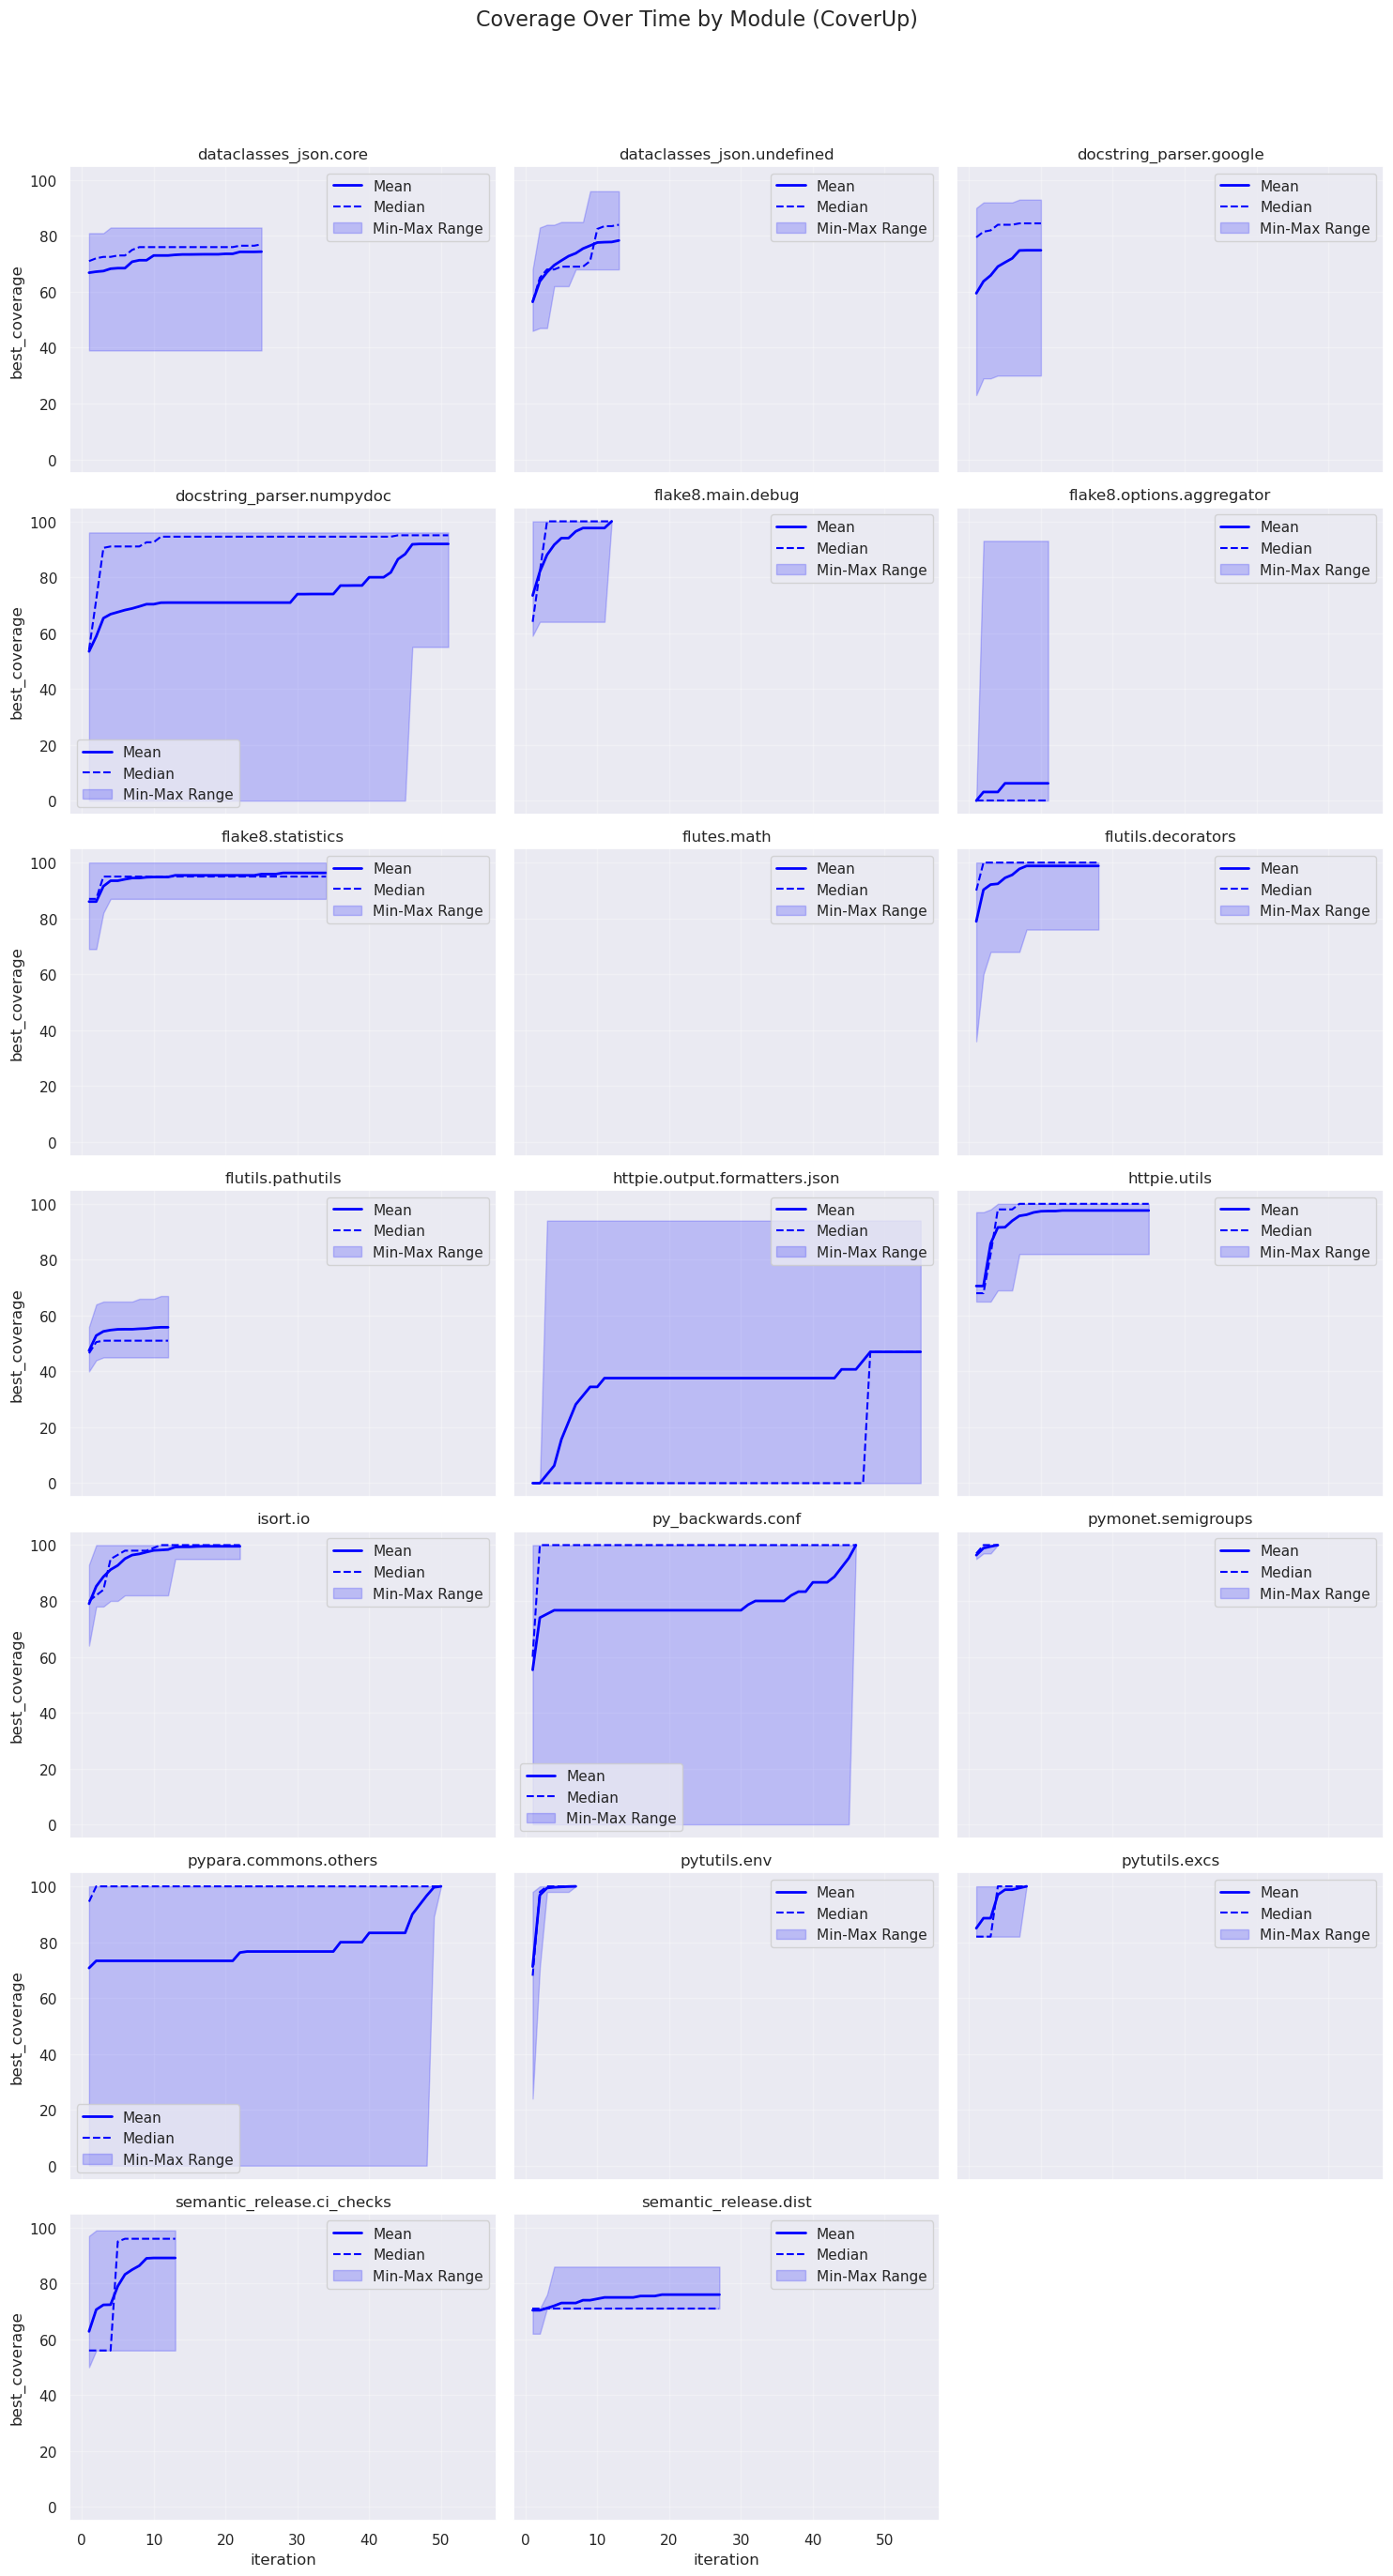

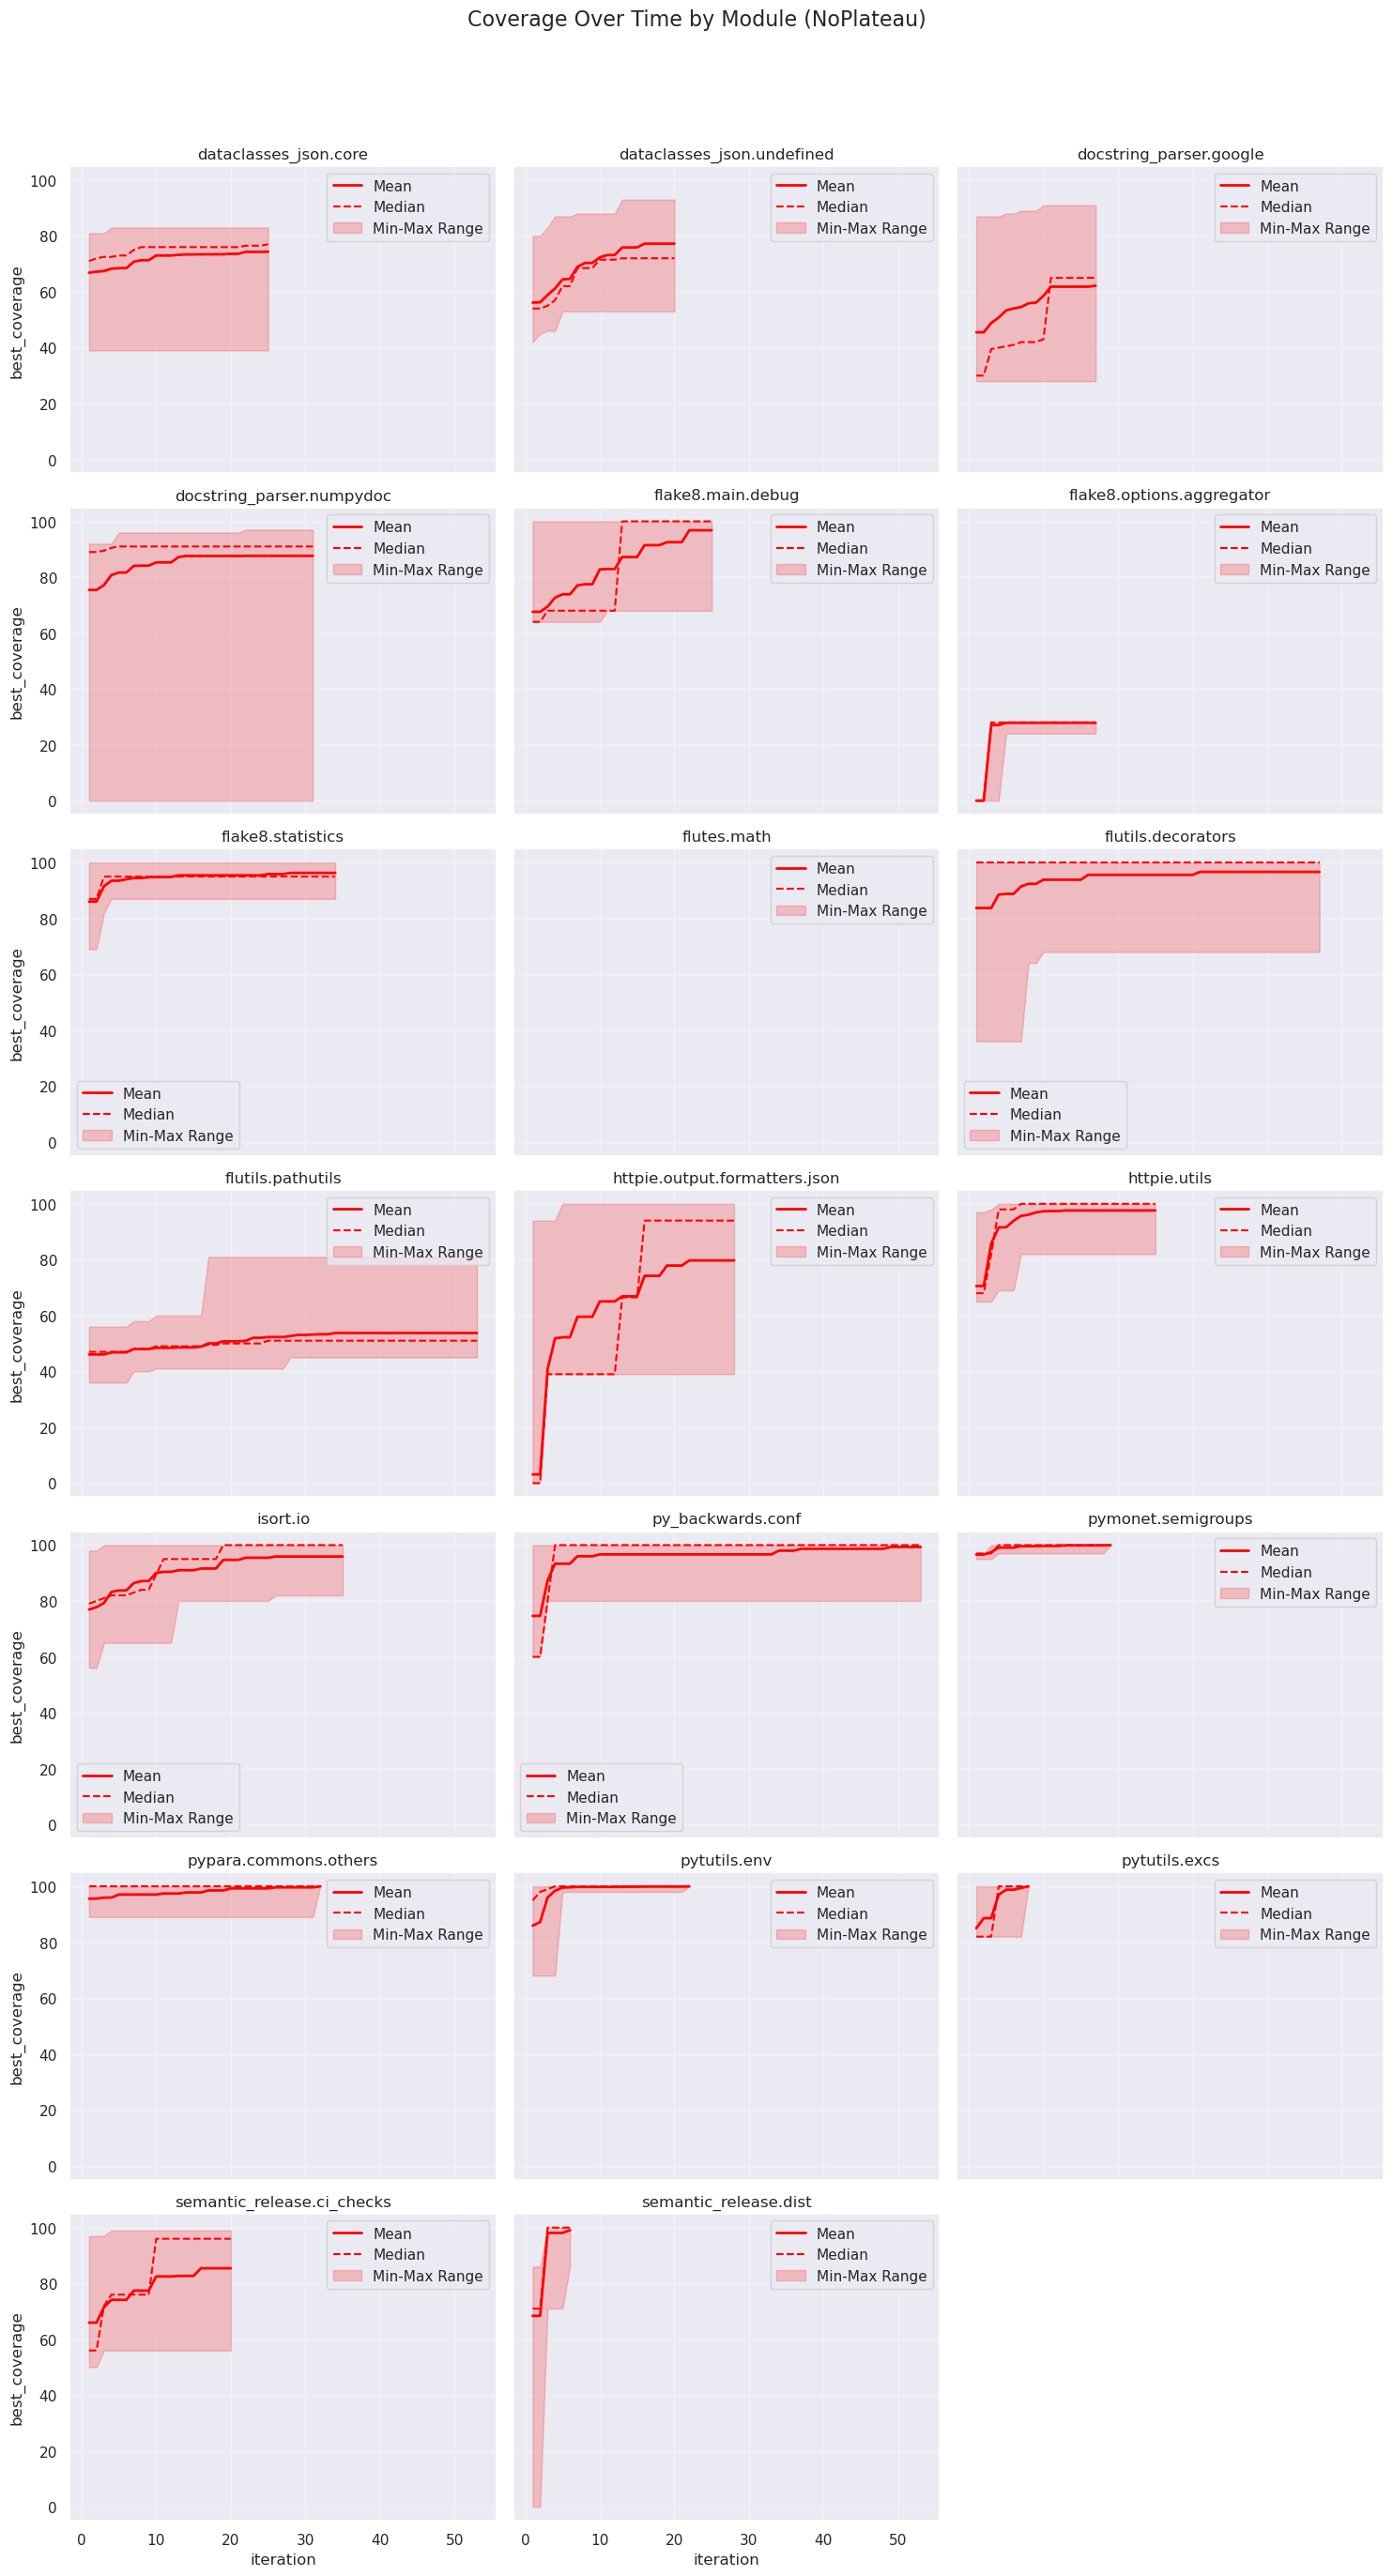

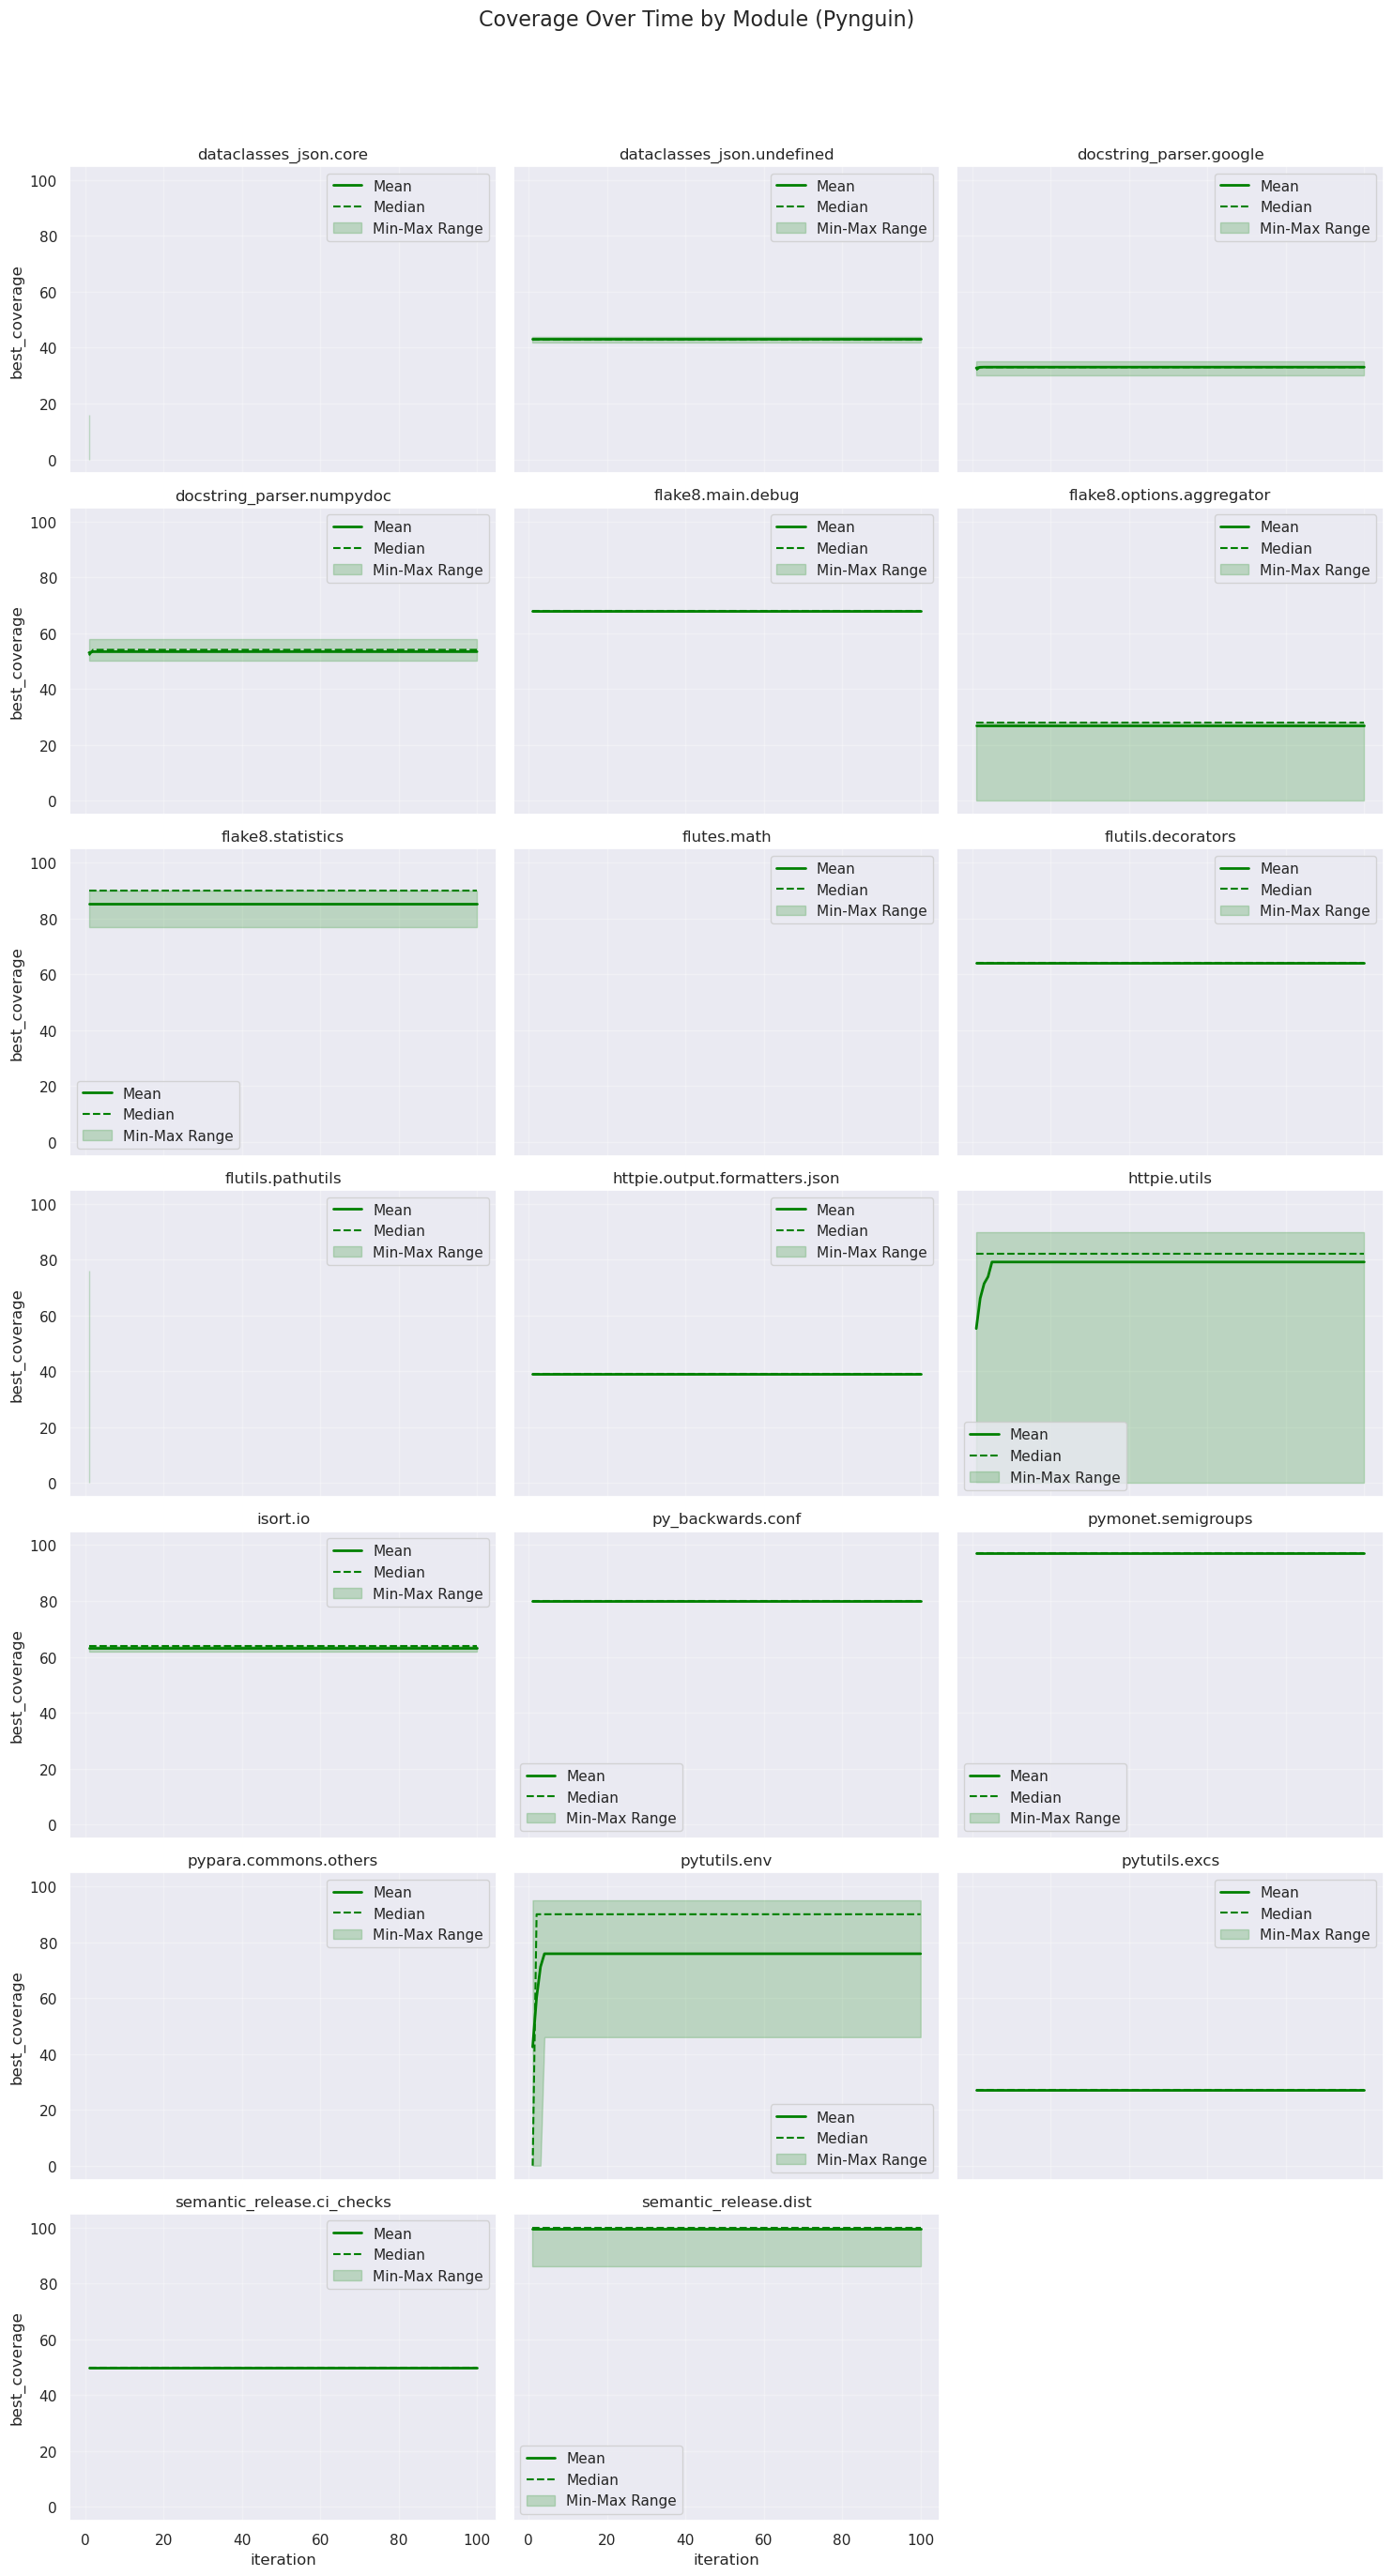

In [11]:
# Plot coverage over time by module for each tool, saving an individual image for each tool

for tool in tools:
    tool_data = grouped[grouped['tool'] == tool]
    modules = sorted(tool_data['module'].unique())
    n_modules = len(modules)
    n_cols = min(3, n_modules)
    n_rows = (n_modules + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

    for i, module in enumerate(modules):
        ax = axes[i]
        module_data = tool_data[tool_data['module'] == module].copy()

        # Convert columns to numeric for plotting
        module_data[time_column] = pd.to_numeric(module_data[time_column], errors='coerce')
        module_data['mean'] = pd.to_numeric(module_data['mean'], errors='coerce')
        module_data['median'] = pd.to_numeric(module_data['median'], errors='coerce')
        module_data['min'] = pd.to_numeric(module_data['min'], errors='coerce')
        module_data['max'] = pd.to_numeric(module_data['max'], errors='coerce')

        color = tool_colors.get(tool, 'gray')

        # Plot mean line
        ax.plot(module_data[time_column], module_data['mean'],
                color=color,
                linewidth=2,
                label='Mean')

        # Plot median line
        ax.plot(module_data[time_column], module_data['median'],
                color=color,
                linestyle='--',
                linewidth=1.5,
                label='Median')

        # Add shaded area for min-max range
        ax.fill_between(module_data[time_column],
                        module_data['min'],
                        module_data['max'],
                        color=color,
                        alpha=0.2,
                        label='Min-Max Range')

        ax.set_title(f'{module}')
        ax.grid(True, alpha=0.3)
        ax.legend()

        if i % n_cols == 0:
            ax.set_ylabel(coverage_column)
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel(time_column)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Coverage Over Time by Module ({tool})', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/coverage_over_time_by_module_{tool}.png', dpi=300, bbox_inches='tight')
    plt.show()


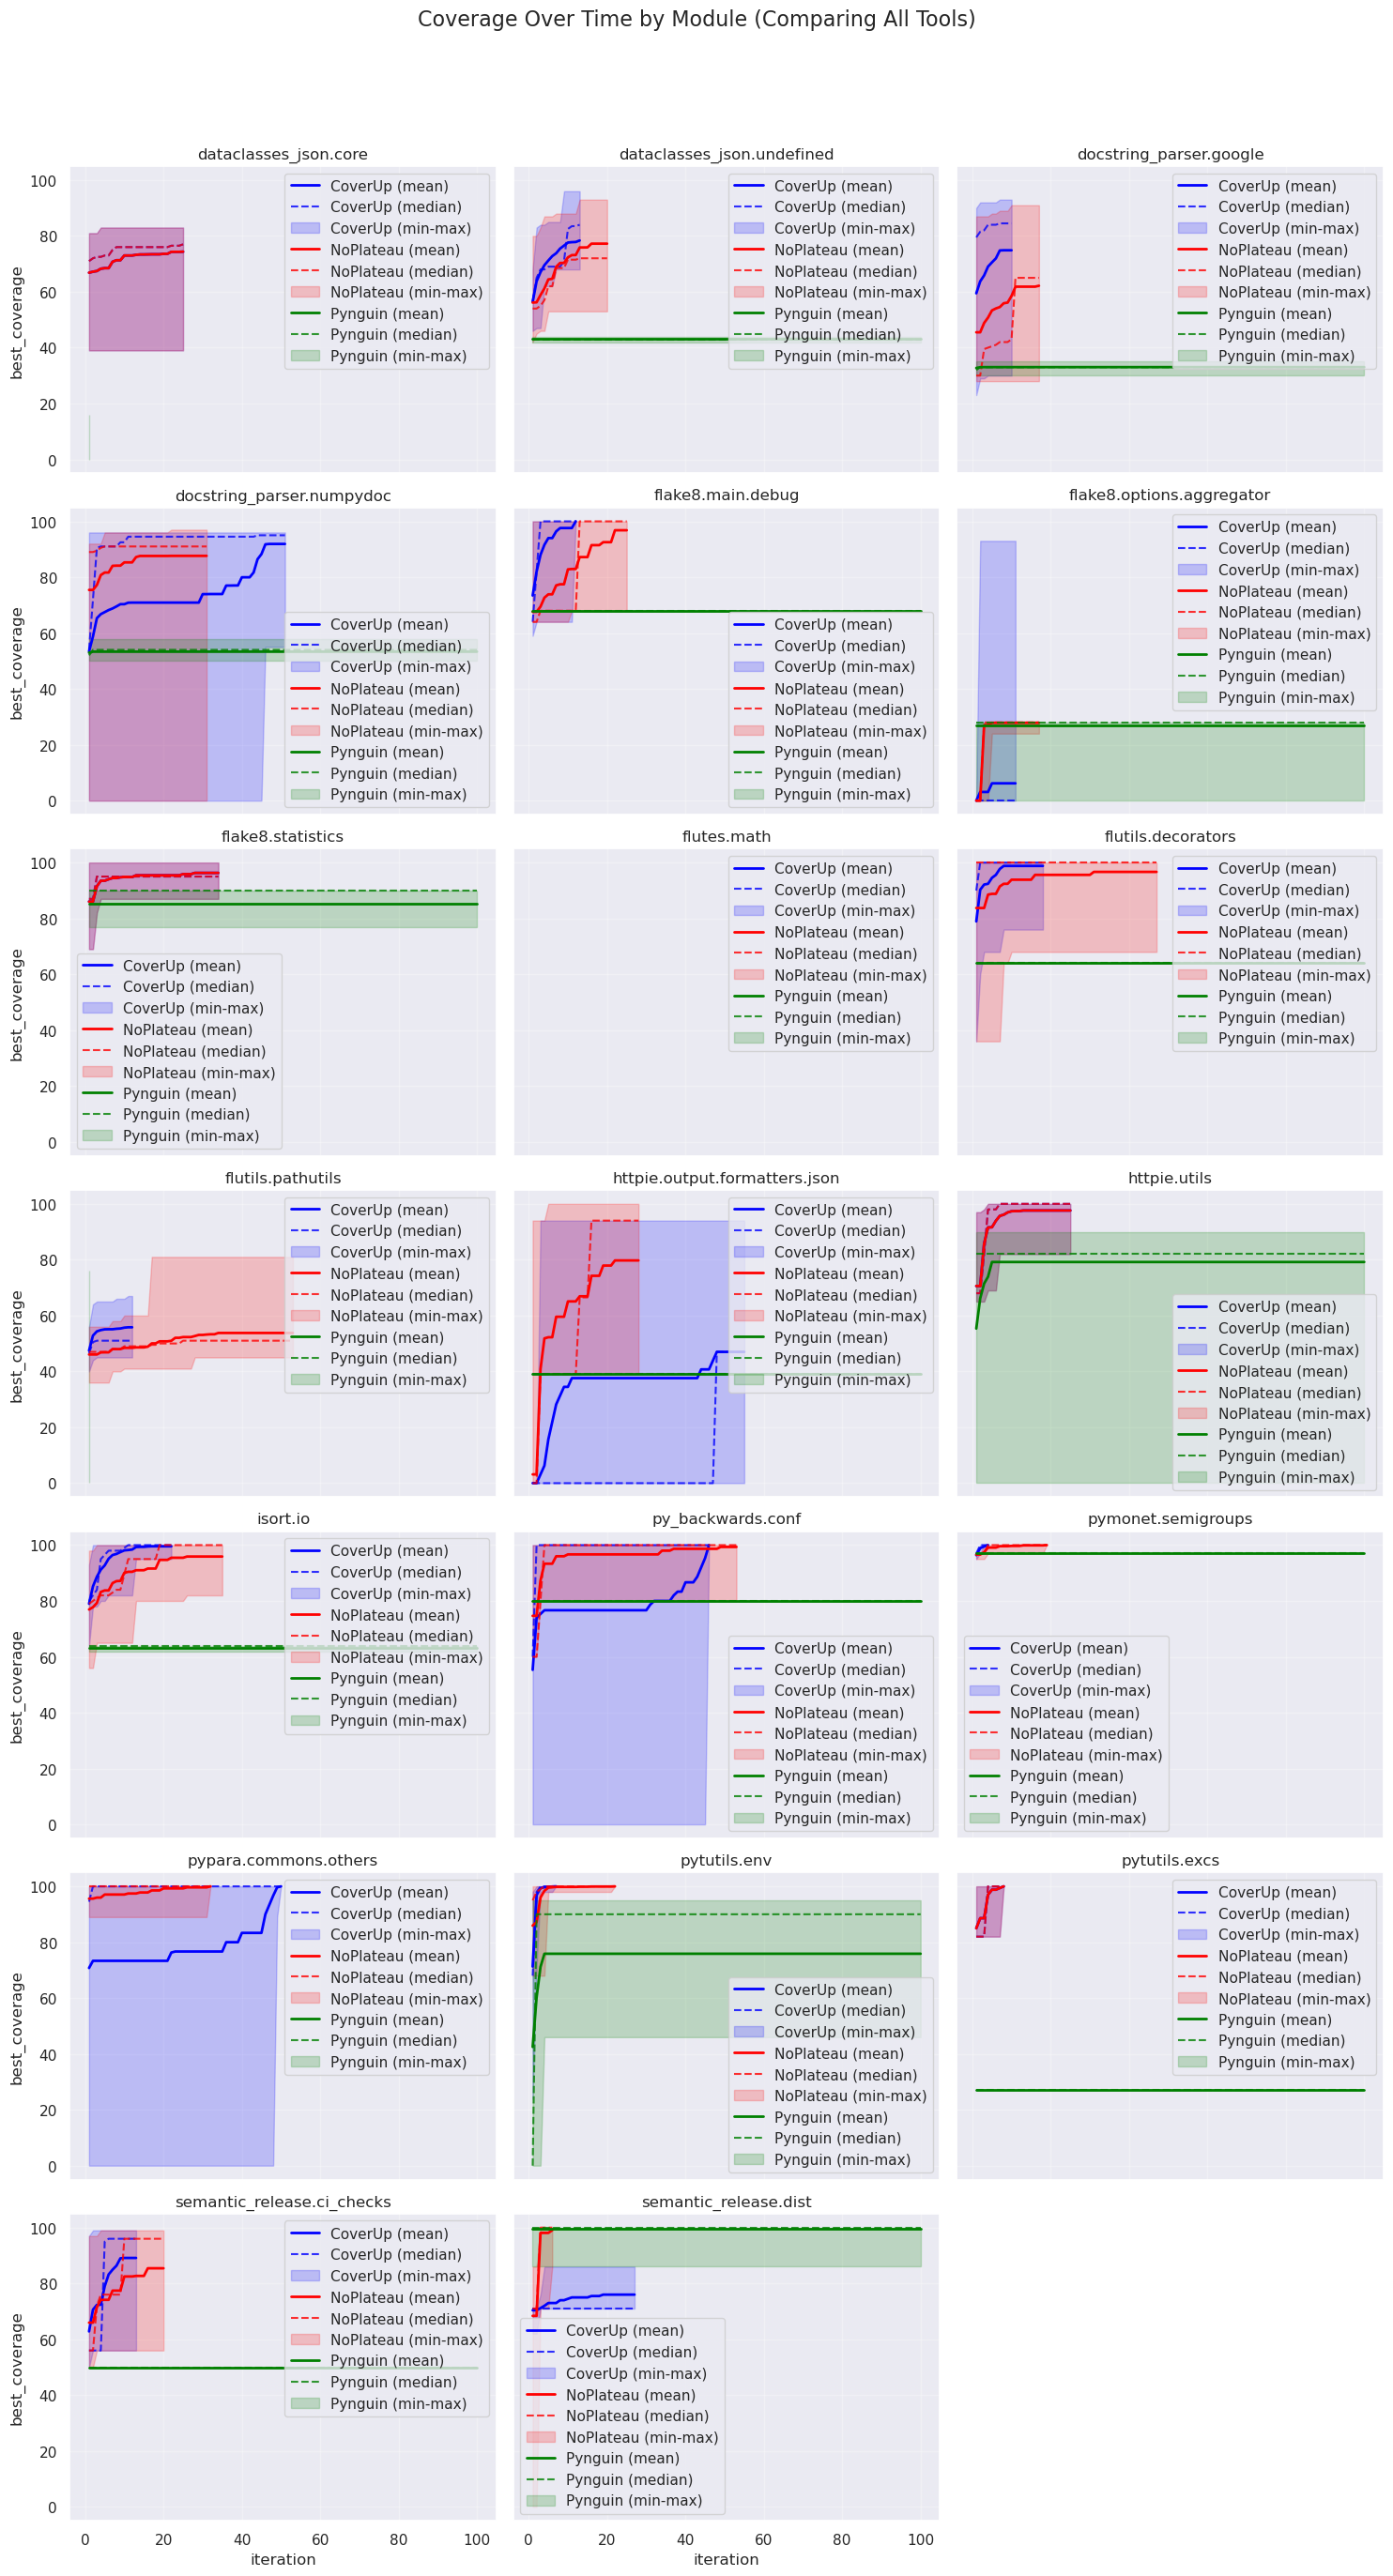

In [12]:
# Plot with the original grouped data (no extension needed)
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True, sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = grouped[grouped['module'] == module].copy()
    
    # Convert columns to numeric for plotting
    module_data[time_column] = pd.to_numeric(module_data[time_column], errors='coerce')
    module_data['mean'] = pd.to_numeric(module_data['mean'], errors='coerce')
    module_data['median'] = pd.to_numeric(module_data['median'], errors='coerce')
    module_data['min'] = pd.to_numeric(module_data['min'], errors='coerce')
    module_data['max'] = pd.to_numeric(module_data['max'], errors='coerce')
    
    # Plot each tool separately
    for tool in tools:
        tool_data = module_data[module_data['tool'] == tool]
        if len(tool_data) > 0:
            color = tool_colors.get(tool, 'gray')
            
            # Plot mean line
            ax.plot(tool_data[time_column], tool_data['mean'], 
                    color=color, 
                    linewidth=2, 
                    label=f'{tool} (mean)',
                    linestyle='-')
            
            # Plot median line
            ax.plot(tool_data[time_column], tool_data['median'],
                    color=color,
                    linestyle='--',
                    linewidth=1.5,
                    label=f'{tool} (median)',
                    alpha=0.8)
            
            # Add shaded area for min-max range
            ax.fill_between(tool_data[time_column], 
                           tool_data['min'], 
                           tool_data['max'], 
                           color=color, 
                           alpha=0.2, 
                           label=f'{tool} (min-max)')
    
    ax.set_title(f'{module}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    if i % n_cols == 0:
        ax.set_ylabel(coverage_column)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel(time_column)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Coverage Over Time by Module (Comparing All Tools)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/coverage_over_time_by_module_all_tools.png', dpi=300, bbox_inches='tight')
plt.show()


## Analysis of Final Coverage by Experiment


/tmp/ipykernel_105861/13208679.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_105861/13208679.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_105861/13208679.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
/tmp/ipykernel_105861/13208679.py:25: FutureWarning: 

Passing `palett

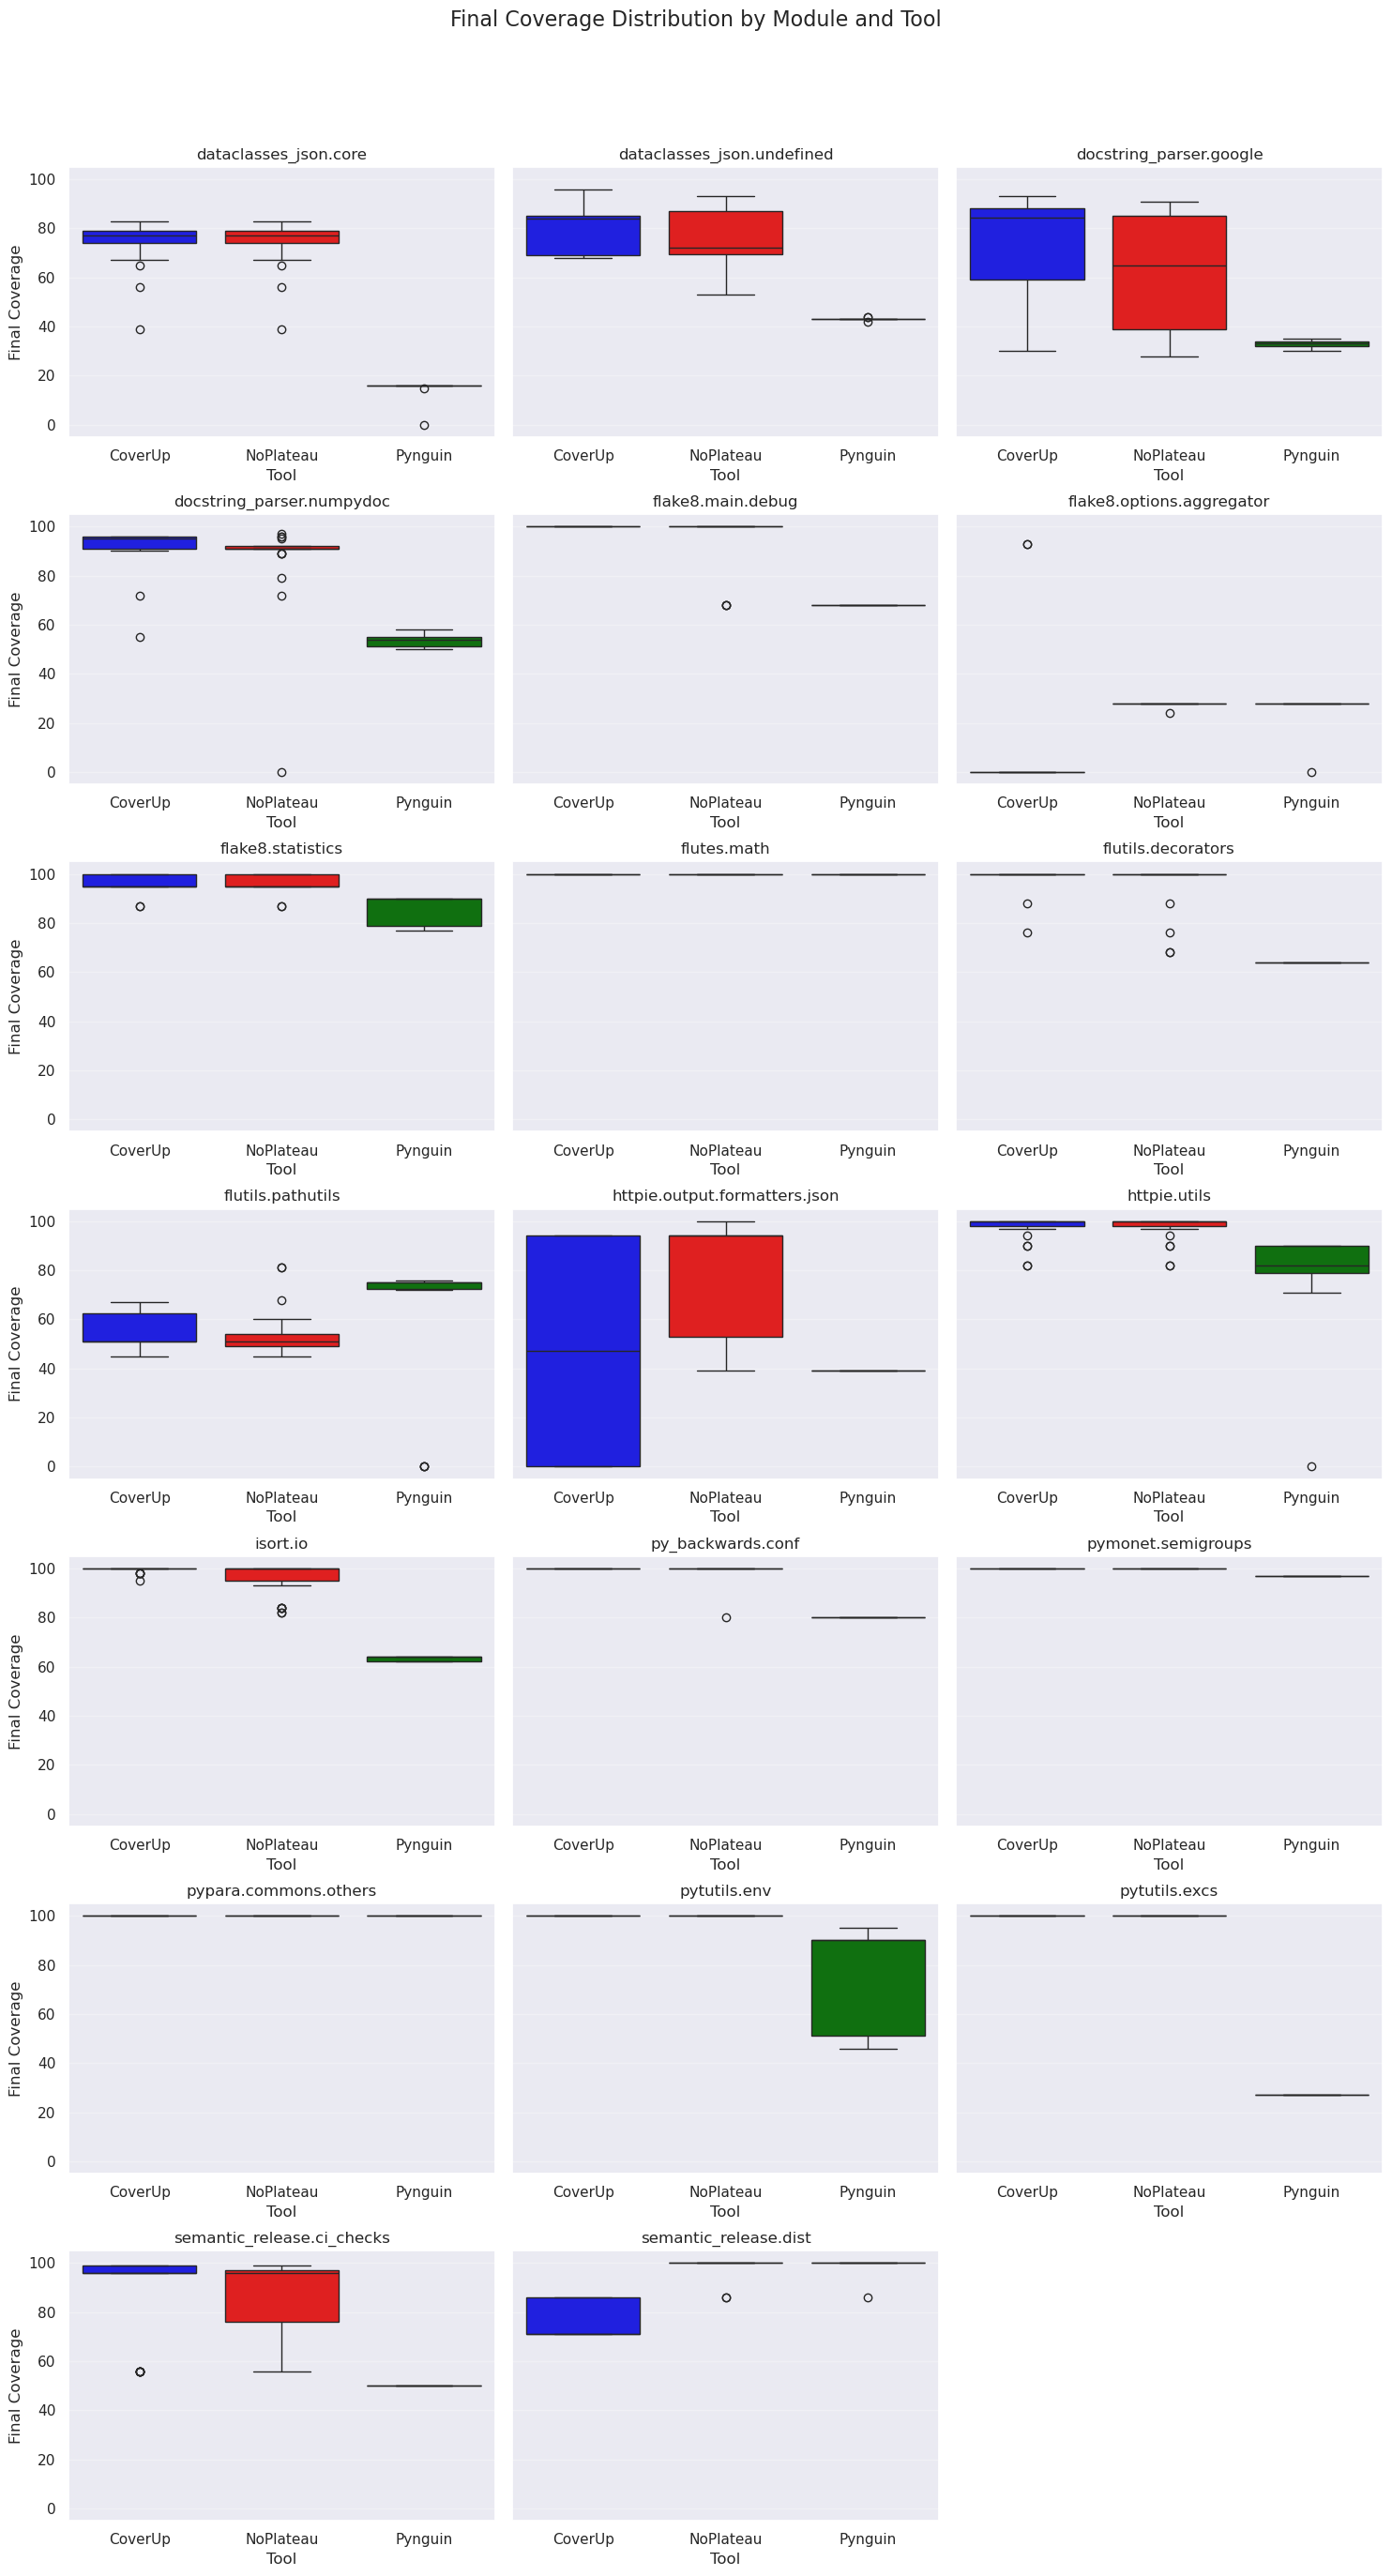

/tmp/ipykernel_105861/13208679.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors)


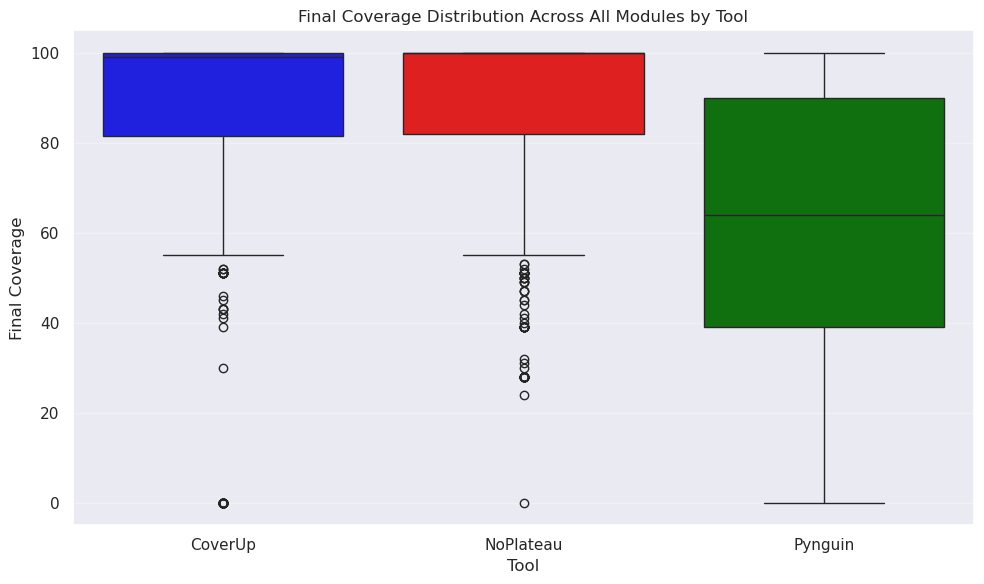

In [13]:
# Analyze the final coverage distribution by module as a boxplot

# For each run, get the final (max iteration) best_coverage
final_coverage = (
    combined_df
    .sort_values(['module', 'tool', 'module_run_num', 'iteration'])
    .groupby(['module', 'tool', 'module_run_num'])
    .tail(1)
)

# Create subplot for each module
modules = sorted(final_coverage['module'].unique())
n_modules = len(modules)
n_cols = min(3, n_modules)
n_rows = (n_modules + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, module in enumerate(modules):
    ax = axes[i]
    module_data = final_coverage[final_coverage['module'] == module]
    
    # Create boxplot for this module
    sns.boxplot(data=module_data, x='tool', y='best_coverage', ax=ax, palette=tool_colors)
    ax.set_title(f'{module}')
    ax.set_xlabel('Tool')
    ax.set_ylabel('Final Coverage')
    ax.grid(True, axis='y', alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Final Coverage Distribution by Module and Tool', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig('figures/final_coverage_distribution_all_tools.png', dpi=300, bbox_inches='tight')
plt.show()

# Overall comparison across all modules
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors)
plt.title('Final Coverage Distribution Across All Modules by Tool')
plt.xlabel('Tool')
plt.ylabel('Final Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_coverage_overall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_105861/1686638617.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')


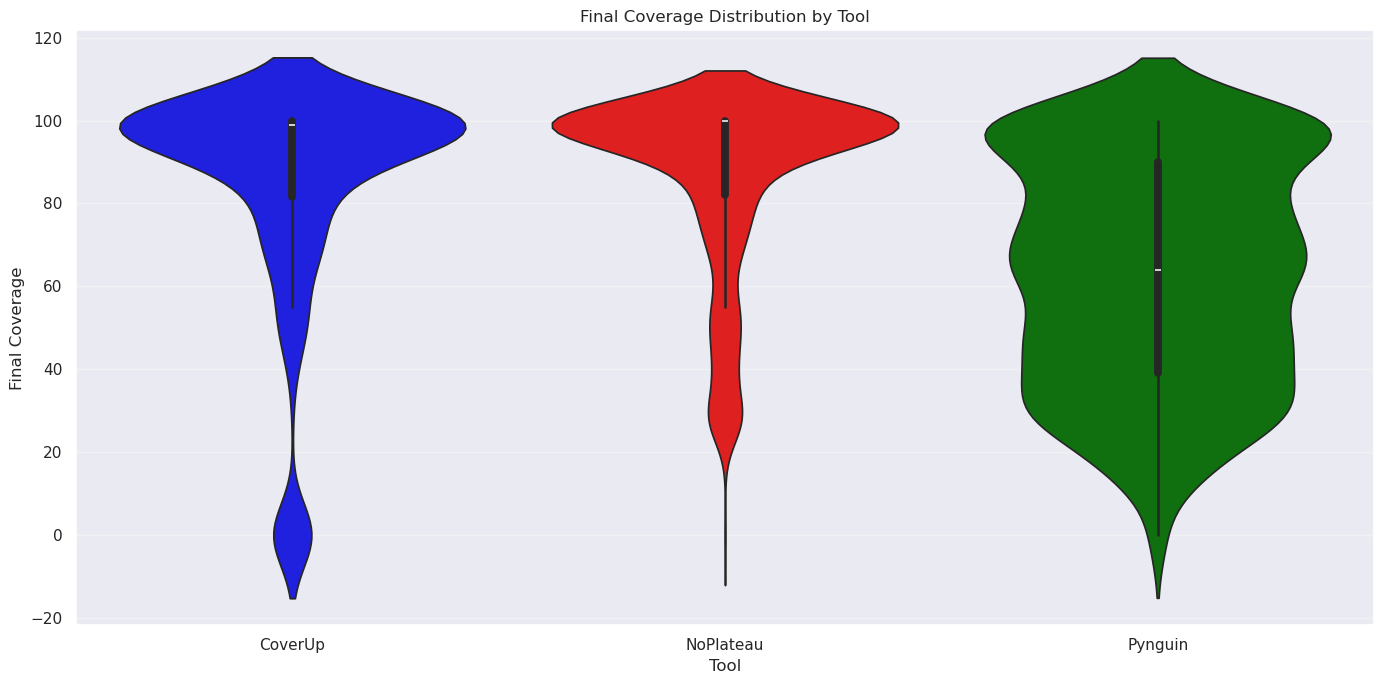

In [14]:
# Violin plot of final best coverage by tool for each module

plt.figure(figsize=(14, 7))
sns.violinplot(data=final_coverage, x='tool', y='best_coverage', palette=tool_colors, inner='box')
plt.title('Final Coverage Distribution by Tool')
plt.xlabel('Tool')
plt.ylabel('Final Coverage')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_coverage_violin_by_tool.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Calculate the percentage of runs with final best_coverage below the tail for each tool
tail = 30

# Ensure best_coverage is numeric
final_coverage['best_coverage'] = pd.to_numeric(final_coverage['best_coverage'], errors='coerce')

percent_below_tail = (
    final_coverage.groupby('tool')
    .apply(lambda df: (df['best_coverage'] < tail).mean() * 100)
    .rename('percent_below_tail')
    .reset_index()
)

print("Tail cutoff:", tail)
print(percent_below_tail)



Tail cutoff: 30
        tool  percent_below_tail
0    CoverUp            7.178631
1  NoPlateau            5.342237
2    Pynguin           15.771812


/tmp/ipykernel_105861/3653589720.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['best_coverage'] < tail).mean() * 100)


In [16]:
cutoff = 30

# Check the percentage of modules that have below 30% final coverage in both coverup and noplateau 
coverup_modules = final_coverage[final_coverage['tool'] == 'CoverUp']
noplateau_modules = final_coverage[final_coverage['tool'] == 'NoPlateau']
coverup_below_30 = coverup_modules[coverup_modules['best_coverage'] < cutoff]['module'].unique()
noplateau_below_30 = noplateau_modules[noplateau_modules['best_coverage'] < cutoff]['module'].unique()
common_below_30 = set(coverup_below_30) & set(noplateau_below_30)
print(f"Modules with below 30% final coverage in both coverup and noplateau: {len(common_below_30)}")
print("Common modules:", common_below_30)
print(f"Modules with below 30% final coverage in noplateau: {noplateau_below_30}")
print(f"Modules with below 30% final coverage in coverup: {coverup_below_30}")

print()

# Find percentage of runs of those modules that have below 30% final coverage
# For each tool, and for each module that has below 30% final coverage in that tool,
# calculate the percentage of runs with final best_coverage < 30, separated by module

percent_below_30_per_tool_module = {}

for tool, below_30_modules in [
    ('CoverUp', coverup_below_30),
    ('NoPlateau', noplateau_below_30)
]:
    percent_below_30_per_tool_module[tool] = {}
    for module in below_30_modules:
        runs = final_coverage[(final_coverage['tool'] == tool) & (final_coverage['module'] == module)]
        if len(runs) > 0:
            percent = (runs['best_coverage'] < cutoff).mean() * 100
        else:
            percent = np.nan
        percent_below_30_per_tool_module[tool][module] = percent

print("Percentage of runs with <30% final coverage for each module below 30% in each tool:")
for tool, module_percents in percent_below_30_per_tool_module.items():
    print(f"\n{tool}:")
    for module, percent in module_percents.items():
        print(f"  {module}: {percent:.2f}%")

Modules with below 30% final coverage in both coverup and noplateau: 1
Common modules: {'flake8.options.aggregator'}
Modules with below 30% final coverage in noplateau: ['docstring_parser.google' 'docstring_parser.numpydoc'
 'flake8.options.aggregator']
Modules with below 30% final coverage in coverup: ['flake8.options.aggregator' 'httpie.output.formatters.json']

Percentage of runs with <30% final coverage for each module below 30% in each tool:

CoverUp:
  flake8.options.aggregator: 93.33%
  httpie.output.formatters.json: 50.00%

NoPlateau:
  docstring_parser.google: 3.33%
  docstring_parser.numpydoc: 3.33%
  flake8.options.aggregator: 100.00%


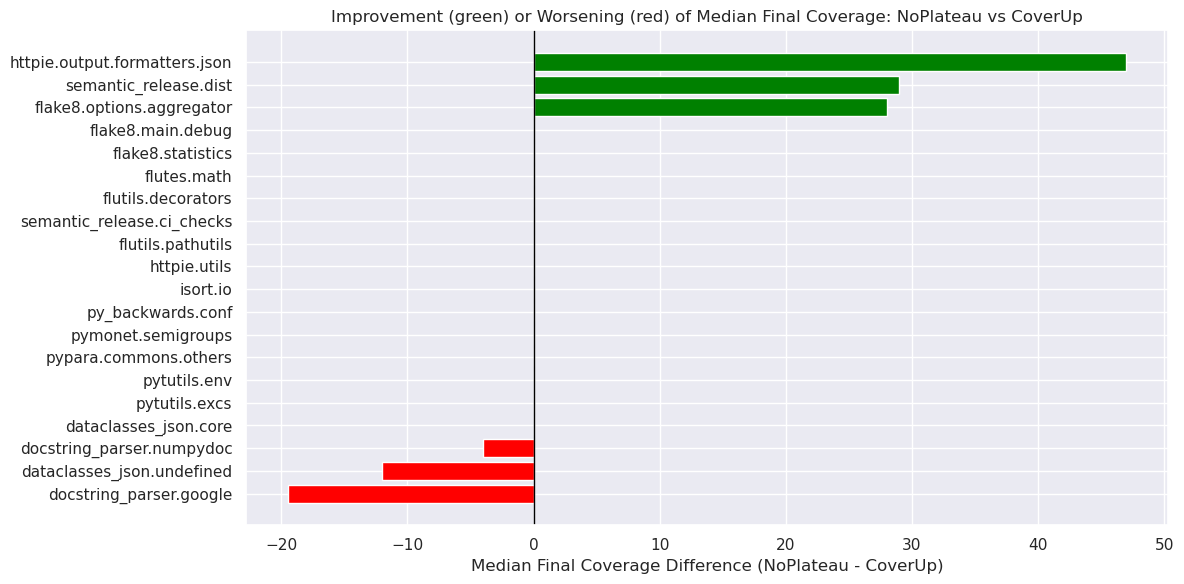

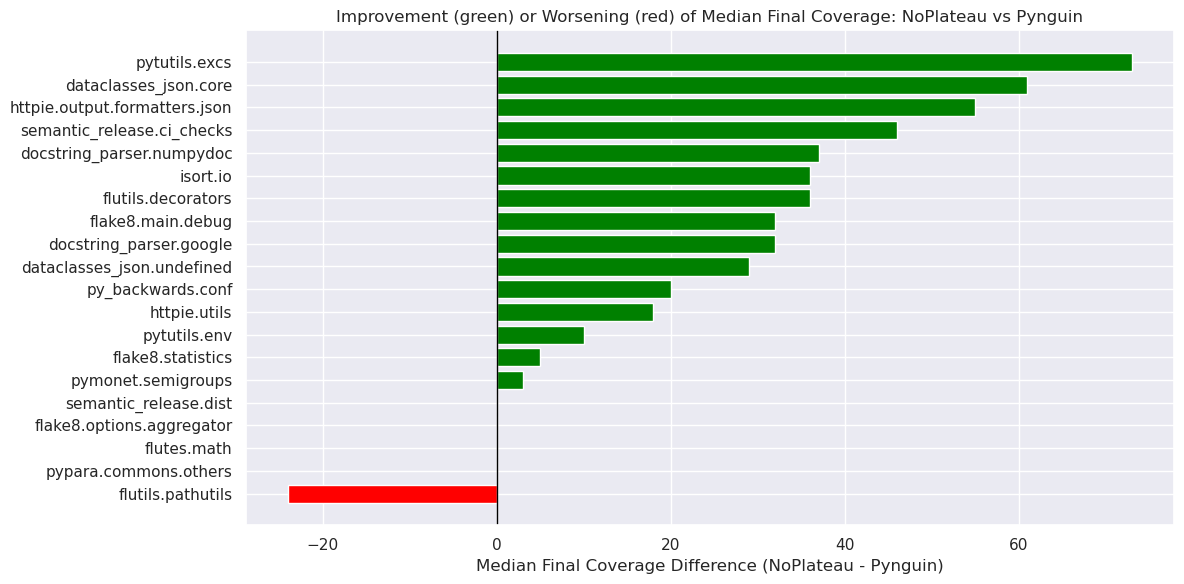

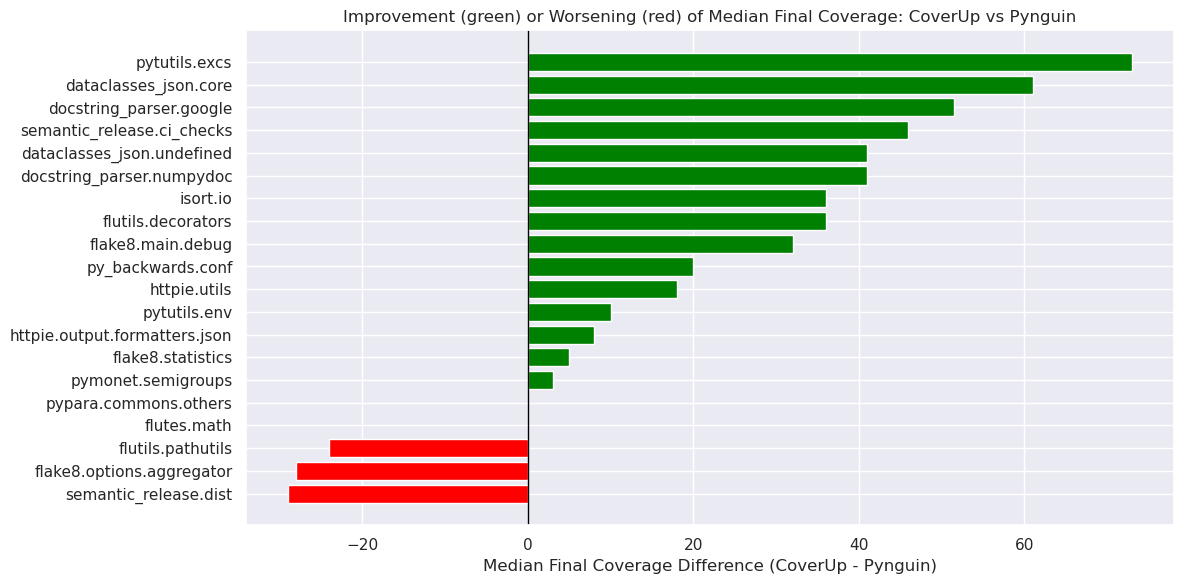

In [17]:
def plot_median_final_coverage_diff(tool_b, tool_a):
    """
    Plot the difference in median final best_coverage between two tools for each module.
    """
    median_final_coverage = (
        final_coverage[final_coverage['tool'].isin([tool_a, tool_b])]
        .groupby(['module', 'tool'])['best_coverage']
        .median()
        .unstack()
    )

    # Compute the difference: tool_b - tool_a
    median_final_coverage['diff'] = median_final_coverage[tool_b] - median_final_coverage[tool_a]

    # Sort modules by difference for better visualization
    median_final_coverage_sorted = median_final_coverage.sort_values('diff')

    # Plot the difference as a bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        median_final_coverage_sorted.index,
        median_final_coverage_sorted['diff'],
        color=np.where(median_final_coverage_sorted['diff'] >= 0, 'green', 'red')
    )
    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel(f'Median Final Coverage Difference ({tool_b} - {tool_a})')
    plt.title(f'Improvement (green) or Worsening (red) of Median Final Coverage: {tool_b} vs {tool_a}')
    plt.tight_layout()
    plt.show()


plot_median_final_coverage_diff('NoPlateau', 'CoverUp')
plot_median_final_coverage_diff('NoPlateau', 'Pynguin')
plot_median_final_coverage_diff('CoverUp', 'Pynguin')

# Statistical Significance Analysis

Set the tools to compare and run the analysis:

In [18]:
# Set the tools to compare
TOOL_A = 'NoPlateau'
TOOL_B = 'Pynguin'

print(f"Comparing {TOOL_A} vs {TOOL_B}")


Comparing NoPlateau vs Pynguin


In [19]:
from scipy.stats import kruskal

kruskal_results = []

for module in modules:
    module_data = final_coverage[final_coverage['module'] == module]
    groups = [group['best_coverage'].astype(float).values for name, group in module_data.groupby('tool')]
    # Only test if at least 2 groups with >1 value and not all values are identical
    flat = np.concatenate(groups)
    if sum(len(g) > 1 for g in groups) >= 2 and not np.all(flat == flat[0]):
        stat, p = kruskal(*groups)
        kruskal_results.append({'module': module, 'statistic': stat, 'p_value': p})
    else:
        kruskal_results.append({'module': module, 'statistic': None, 'p_value': None})

kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis test results (p < 0.05 indicates significant difference among tools):")
display(kruskal_df)


Kruskal-Wallis test results (p < 0.05 indicates significant difference among tools):


,module,statistic,p_value
0,dataclasses_json.core,61.308840,4.863562e-14
1,dataclasses_json.undefined,61.479940,4.464787e-14
2,docstring_parser.google,46.642407,7.442690e-11
3,docstring_parser.numpydoc,59.281411,1.340310e-13
4,flake8.main.debug,77.502392,1.481049e-17
5,flake8.options.aggregator,61.506164,4.406626e-14
6,flake8.statistics,54.424047,1.520437e-12
7,flutes.math,NaN,NaN
8,flutils.decorators,79.570163,5.266942e-18
9,flutils.pathutils,31.491218,1.451339e-07


In [20]:
from scipy.stats import mannwhitneyu

def mannwhitneyu_all_modules(final_coverage, tool_a, tool_b, alternative='two-sided', alpha=0.05, correction='bonferroni'):
    """
    Perform the Mann-Whitney U test for each module between two tools, with multiple testing correction.
    
    Parameters:
        final_coverage (pd.DataFrame): DataFrame with columns ['module', 'tool', 'best_coverage'].
        tool_a (str): Name of the first tool.
        tool_b (str): Name of the second tool.
        alternative (str): Defines the alternative hypothesis ('two-sided', 'less', 'greater').
        alpha (float): Significance level.
        correction (str): Correction method ('bonferroni' or None).
        
    Returns:
        pd.DataFrame: Results with columns ['module', 'u_statistic', 'p_value', 'n_tool_a', 'n_tool_b', 'significant'].
    """
    results = []
    modules = sorted(final_coverage['module'].unique())
    for module in modules:
        data_a = final_coverage[(final_coverage['module'] == module) & (final_coverage['tool'] == tool_a)]['best_coverage'].astype(float)
        data_b = final_coverage[(final_coverage['module'] == module) & (final_coverage['tool'] == tool_b)]['best_coverage'].astype(float)
        n_a, n_b = len(data_a), len(data_b)        
        if n_a > 0 and n_b > 0 and not (data_a.nunique() == 1 and data_b.nunique() == 1 and data_a.iloc[0] == data_b.iloc[0]):
            u_stat, p_val = mannwhitneyu(data_a, data_b, alternative=alternative, nan_policy='raise')
        else:
            u_stat, p_val = None, None
        results.append({
            'module': module,
            'u_statistic': u_stat,
            'p_value': p_val,
            'n_tool_a': n_a,
            'n_tool_b': n_b
        })
    df = pd.DataFrame(results)
    # Multiple testing correction
    if correction == 'bonferroni':
        corrected_alpha = alpha / len(df)
    else:
        corrected_alpha = alpha
    df['significant'] = (df['p_value'] < corrected_alpha)
    return df

print(f"Is {TOOL_A} significantly better than {TOOL_B}?")
mw_df = mannwhitneyu_all_modules(final_coverage, TOOL_A, TOOL_B)
display(mw_df)

Is NoPlateau significantly better than Pynguin?


,module,u_statistic,p_value,n_tool_a,n_tool_b,significant
0,dataclasses_json.core,900.0,2.316649e-12,30,30,True
1,dataclasses_json.undefined,900.0,2.980798e-12,30,30,True
2,docstring_parser.google,789.5,4.631106e-07,30,30,True
3,docstring_parser.numpydoc,870.0,3.485834e-10,30,30,True
4,flake8.main.debug,855.0,3.941029e-12,30,30,True
5,flake8.options.aggregator,450.5,1.000000e+00,30,30,False
6,flake8.statistics,864.0,3.010274e-10,30,30,True
7,flutes.math,NaN,NaN,30,30,False
8,flutils.decorators,900.0,8.721634e-14,30,30,True
9,flutils.pathutils,138.0,1.840128e-05,30,27,True


len(mw_df): 20


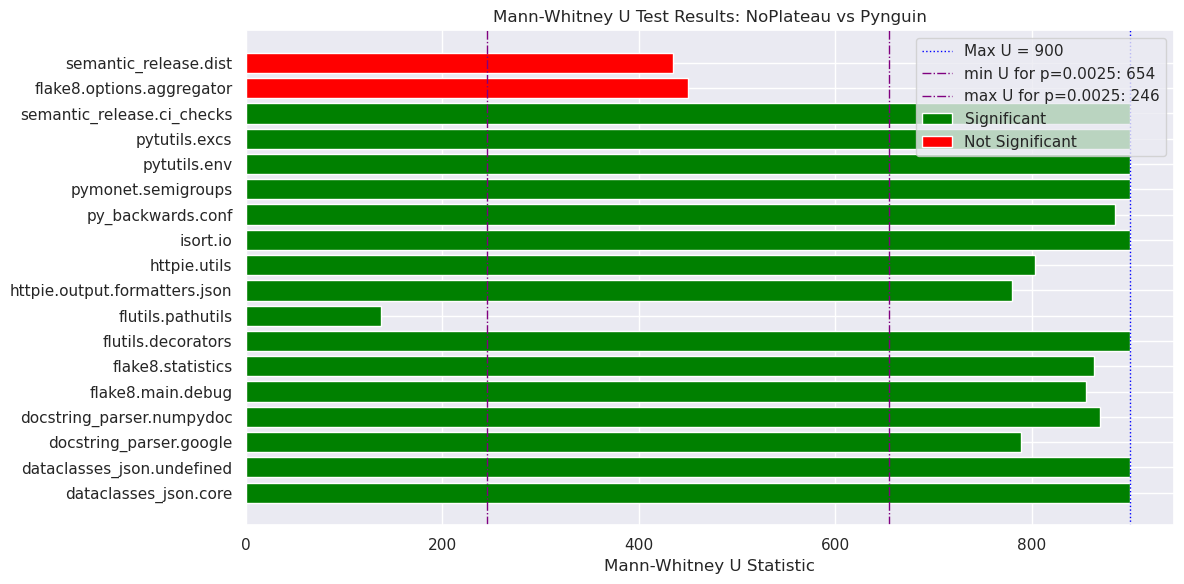

In [21]:
# Plot the results of the Mann-Whitney U test, also showing the max U statistic and the minimum U value that would be significant
def plot_mannwhitneyu_results(mw_df, tool_a, tool_b, alpha=0.05):
    """
    Plot the results of the Mann-Whitney U test for each module.
    Also shows the maximum possible U statistic as a vertical line,
    and the minimum U value at which the result would be significant.
    """
    import scipy.stats as stats

    corrected_alpha = alpha / len(mw_df) if not mw_df.empty else alpha

    significant = mw_df[mw_df['significant'] & mw_df['u_statistic'].notnull()]
    non_significant = mw_df[~mw_df['significant'] & mw_df['u_statistic'].notnull()]

    plt.figure(figsize=(12, 6))
    plt.barh(significant['module'], significant['u_statistic'], color='green', label='Significant')
    plt.barh(non_significant['module'], non_significant['u_statistic'], color='red', label='Not Significant')

    # Show max U statistic (n_a * n_b) as a vertical line
    if not mw_df.empty:
        n_a = mw_df['n_tool_a'].max()
        n_b = mw_df['n_tool_b'].max()
        max_u = n_a * n_b
        plt.axvline(max_u, color='blue', linewidth=1, linestyle=':', label=f'Max U = {max_u}')

        # Calculate the minimum U value that would be significant (critical value)
        # Use the smallest n_a, n_b for conservative estimate
        min_n_a = mw_df['n_tool_a'].median()
        min_n_b = mw_df['n_tool_b'].median()
        min_n_a = 30
        min_n_b = 30
        if min_n_a > 0 and min_n_b > 0:
            # Use normal approximation for large samples
            mean_U = min_n_a * min_n_b / 2
            std_U = np.sqrt(min_n_a * min_n_b * (min_n_a + min_n_b + 1) / 12)
            # One-sided test (as in your code)
            z_crit = stats.norm.ppf(1 - corrected_alpha/2)
            min_sig_u = mean_U + z_crit * std_U
            max_sig_u = mean_U - z_crit * std_U
            plt.axvline(min_sig_u, color='purple', linewidth=1, linestyle='-.', label=f'min U for p={corrected_alpha:.4f}: {min_sig_u:.0f}')
            plt.axvline(max_sig_u, color='purple', linewidth=1, linestyle='-.', label=f'max U for p={corrected_alpha:.4f}: {max_sig_u:.0f}')

    plt.xlabel('Mann-Whitney U Statistic')
    plt.title(f'Mann-Whitney U Test Results: {tool_a} vs {tool_b}')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("len(mw_df):", len(mw_df))
plot_mannwhitneyu_results(mw_df, TOOL_A, TOOL_B)

In [22]:
import itertools as it

from bisect import bisect_left
from typing import List

import numpy as np
import pandas as pd
import scipy.stats as ss

from pandas import Categorical


def VD_A(treatment: List[float], control: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000

    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/

    :param treatment: a numeric list
    :param control: another numeric list

    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    #if m != n:
    #    raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude


def VD_A_DF(data, val_col: str = None, group_col: str = None, sort=True):
    """

    :param data: pandas DataFrame object
        An array, any object exposing the array interface or a pandas DataFrame.
        Array must be two-dimensional. Second dimension may vary,
        i.e. groups may have different lengths.
    :param val_col: str, optional
        Must be specified if `a` is a pandas DataFrame object.
        Name of the column that contains values.
    :param group_col: str, optional
        Must be specified if `a` is a pandas DataFrame object.
        Name of the column that contains group names.
    :param sort : bool, optional
        Specifies whether to sort DataFrame by group_col or not. Recommended
        unless you sort your data manually.

    :return: stats : pandas DataFrame of effect sizes

    Stats summary ::
    'A' : Name of first measurement
    'B' : Name of second measurement
    'estimate' : effect sizes
    'magnitude' : magnitude

    """

    x = data.copy()
    if sort:
        x[group_col] = Categorical(x[group_col], categories=x[group_col].unique(), ordered=True)
        x.sort_values(by=[group_col, val_col], ascending=True, inplace=True)

    groups = x[group_col].unique()

    # Pairwise combinations
    g1, g2 = np.array(list(it.combinations(np.arange(groups.size), 2))).T

    # Compute effect size for each combination
    ef = np.array([VD_A(list(x[val_col][x[group_col] == groups[i]].values),
                        list(x[val_col][x[group_col] == groups[j]].values)) for i, j in zip(g1, g2)])

    return pd.DataFrame({
        'A': np.unique(data[group_col])[g1],
        'B': np.unique(data[group_col])[g2],
        'estimate': ef[:, 0],
        'magnitude': ef[:, 1]
    })


if __name__ == '__main__':
    # Examples

    # negligible
    F = [0.8236111111111111, 0.7966666666666666, 0.923611111111111, 0.8197222222222222, 0.7108333333333333]
    G = [0.8052777777777779, 0.8172222222222221, 0.8322222222222223, 0.783611111111111, 0.8141666666666666]
    print(VD_A(G, F))

    # small
    A = [0.478515625, 0.4638671875, 0.4638671875, 0.4697265625, 0.4638671875, 0.474609375, 0.4814453125, 0.4814453125,
         0.4697265625, 0.4814453125, 0.474609375, 0.4833984375, 0.484375, 0.44921875, 0.474609375, 0.484375,
         0.4814453125, 0.4638671875, 0.484375, 0.478515625, 0.478515625, 0.45703125, 0.484375, 0.419921875,
         0.4833984375, 0.478515625, 0.4697265625, 0.484375, 0.478515625, 0.4638671875]
    B = [0.4814453125, 0.478515625, 0.44921875, 0.4814453125, 0.4638671875, 0.478515625, 0.474609375, 0.4638671875,
         0.474609375, 0.44921875, 0.474609375, 0.478515625, 0.478515625, 0.474609375, 0.4697265625, 0.474609375,
         0.45703125, 0.4697265625, 0.478515625, 0.4697265625, 0.4697265625, 0.484375, 0.45703125, 0.474609375,
         0.474609375, 0.4638671875, 0.45703125, 0.474609375, 0.4638671875, 0.4306640625]

    print(VD_A(A, B))

    # medium
    C = [0.9108333333333334, 0.8755555555555556, 0.900277777777778, 0.9274999999999999, 0.8777777777777779]
    E = [0.8663888888888888, 0.8802777777777777, 0.7816666666666667, 0.8377777777777776, 0.9305555555555556]
    print(VD_A(C, E))

    # Large
    D = [0.7202777777777778, 0.77, 0.8544444444444445, 0.7947222222222222, 0.7577777777777778]
    print(VD_A(C, D))


(0.44, 'negligible')
(0.6405555555555555, 'small')
(0.72, 'medium')
(1.0, 'large')


In [23]:
# Calculate A12 (Vargha-Delaney A) effect sizes for comparing the two tools

a12_results = []

for module in modules:
    # Select final coverage for this module and the two tools
    data = final_coverage[
        (final_coverage['module'] == module) &
        (final_coverage['tool'].isin([TOOL_A, TOOL_B]))
    ][['tool', 'best_coverage']].copy()
    # Only calculate if both tools have data
    if data['tool'].nunique() == 2:
        # Rename columns for VD_A_DF
        data = data.rename(columns={'tool': 'group', 'best_coverage': 'value'})
        # Compute effect size
        vd_df = VD_A_DF(data, val_col='value', group_col='group')
        row = vd_df.iloc[0]
        A, B = row['A'], row['B']
        estimate = float(row['estimate'])
        magnitude = row['magnitude']
        # Flip if A is TOOL_B and B is TOOL_A (we want TOOL_A vs TOOL_B)
        if A == TOOL_B and B == TOOL_A:
            A, B = B, A
            estimate = 1 - estimate
        a12_results.append({
            'module': module,
            'A': A,
            'B': B,
            'estimate': estimate,
            'magnitude': magnitude
        })

a12_df = pd.DataFrame(a12_results)
print(f"Vargha-Delaney A12 effect sizes ({TOOL_A} vs {TOOL_B}):")
display(a12_df)

Vargha-Delaney A12 effect sizes (NoPlateau vs Pynguin):


,module,A,B,estimate,magnitude
0,dataclasses_json.core,NoPlateau,Pynguin,1.000000,large
1,dataclasses_json.undefined,NoPlateau,Pynguin,1.000000,large
2,docstring_parser.google,NoPlateau,Pynguin,0.877222,large
3,docstring_parser.numpydoc,NoPlateau,Pynguin,0.966667,large
4,flake8.main.debug,NoPlateau,Pynguin,0.950000,large
5,flake8.options.aggregator,NoPlateau,Pynguin,0.500556,negligible
6,flake8.statistics,NoPlateau,Pynguin,0.960000,large
7,flutes.math,NoPlateau,Pynguin,0.500000,negligible
8,flutils.decorators,NoPlateau,Pynguin,1.000000,large
9,flutils.pathutils,NoPlateau,Pynguin,0.170370,large


In [24]:
def get_stats(final_coverage, tool_a, tool_b):
    stats = []
    for module in modules:
        vals_a = final_coverage[(final_coverage['module'] == module) & (final_coverage['tool'] == tool_a)]['best_coverage'].astype(float)
        vals_b = final_coverage[(final_coverage['module'] == module) & (final_coverage['tool'] == tool_b)]['best_coverage'].astype(float)
        stats.append({
            'module': module,
            f'{tool_a}_mean': vals_a.mean(),
            f'{tool_a}_median': vals_a.median(),
            f'{tool_a}_std': vals_a.std(),
            f'{tool_b}_mean': vals_b.mean(),
            f'{tool_b}_median': vals_b.median(),
            f'{tool_b}_std': vals_b.std(),
        })
    return pd.DataFrame(stats)

stats_df = get_stats(final_coverage, TOOL_A, TOOL_B)
print(f"Descriptive statistics for {TOOL_A} and {TOOL_B}:")
display(stats_df)

Descriptive statistics for NoPlateau and Pynguin:


,module,NoPlateau_mean,NoPlateau_median,NoPlateau_std,Pynguin_mean,Pynguin_median,Pynguin_std
0,dataclasses_json.core,74.366667,77.0,8.895886,15.433333,16.0,2.920597
1,dataclasses_json.undefined,77.233333,72.0,10.430999,43.033333,43.0,0.319842
2,docstring_parser.google,62.166667,65.0,24.020226,33.033333,33.0,1.325697
3,docstring_parser.numpydoc,87.633333,91.0,17.187572,53.333333,54.0,2.106367
4,flake8.main.debug,96.800000,100.0,9.764114,68.000000,68.0,0.000000
5,flake8.options.aggregator,27.866667,28.0,0.730297,27.066667,28.0,5.112077
6,flake8.statistics,96.300000,95.0,3.485438,85.133333,90.0,6.095410
7,flutes.math,100.000000,100.0,0.000000,100.000000,100.0,0.000000
8,flutils.decorators,96.666667,100.0,9.162643,64.000000,64.0,0.000000
9,flutils.pathutils,53.766667,51.0,8.973844,66.185185,75.0,23.881175


# Export Results to LaTeX Table

Merge all results and generate LaTeX table:

In [25]:
# Merge all results
merged_stats = pd.merge(
    mw_df,
    a12_df.rename(columns={'estimate': 'A12_estimate', 'magnitude': 'A12_magnitude'}),
    how='left',
    on='module'
)
merged_stats = pd.merge(merged_stats, stats_df, how='left', on='module')

# Replace NaN p-values with 1 for better readability
merged_stats['p_value'] = merged_stats['p_value'].fillna(1.0)

print(f"Merged Mann-Whitney U, Vargha-Delaney A12, and descriptive stats for {TOOL_A} vs {TOOL_B}:")
display(merged_stats)

Merged Mann-Whitney U, Vargha-Delaney A12, and descriptive stats for NoPlateau vs Pynguin:


,module,u_statistic,p_value,n_tool_a,n_tool_b,significant,A,B,A12_estimate,A12_magnitude,NoPlateau_mean,NoPlateau_median,NoPlateau_std,Pynguin_mean,Pynguin_median,Pynguin_std
0,dataclasses_json.core,900.0,2.316649e-12,30,30,True,NoPlateau,Pynguin,1.000000,large,74.366667,77.0,8.895886,15.433333,16.0,2.920597
1,dataclasses_json.undefined,900.0,2.980798e-12,30,30,True,NoPlateau,Pynguin,1.000000,large,77.233333,72.0,10.430999,43.033333,43.0,0.319842
2,docstring_parser.google,789.5,4.631106e-07,30,30,True,NoPlateau,Pynguin,0.877222,large,62.166667,65.0,24.020226,33.033333,33.0,1.325697
3,docstring_parser.numpydoc,870.0,3.485834e-10,30,30,True,NoPlateau,Pynguin,0.966667,large,87.633333,91.0,17.187572,53.333333,54.0,2.106367
4,flake8.main.debug,855.0,3.941029e-12,30,30,True,NoPlateau,Pynguin,0.950000,large,96.800000,100.0,9.764114,68.000000,68.0,0.000000
5,flake8.options.aggregator,450.5,1.000000e+00,30,30,False,NoPlateau,Pynguin,0.500556,negligible,27.866667,28.0,0.730297,27.066667,28.0,5.112077
6,flake8.statistics,864.0,3.010274e-10,30,30,True,NoPlateau,Pynguin,0.960000,large,96.300000,95.0,3.485438,85.133333,90.0,6.095410
7,flutes.math,NaN,1.000000e+00,30,30,False,NoPlateau,Pynguin,0.500000,negligible,100.000000,100.0,0.000000,100.000000,100.0,0.000000
8,flutils.decorators,900.0,8.721634e-14,30,30,True,NoPlateau,Pynguin,1.000000,large,96.666667,100.0,9.162643,64.000000,64.0,0.000000
9,flutils.pathutils,138.0,1.840128e-05,30,27,True,NoPlateau,Pynguin,0.170370,large,53.766667,51.0,8.973844,66.185185,75.0,23.881175


In [26]:
import re

def format_pval_latex(pval):
    if pd.isnull(pval):
        return ""
    s = f"{pval:.2e}"
    match = re.match(r"([\-0-9.]+)e([\-+0-9]+)", s)
    if match:
        base, exp = match.groups()
        exp = int(exp)
        return f"${base} \\times 10^{{{exp}}}$"
    else:
        return f"${pval:.2f}$"

def effect_latex(a12, significant, magnitude):
    if pd.isnull(a12):
        return ""
    if magnitude == "negligible":
        return r"\equalAndNotSignificant"
    if a12 > 0.5:
        tag = r"\betterAndSignificant" if significant else r"\betterAndNotSignificant"
    elif a12 < 0.5:
        tag = r"\worseAndSignificant" if significant else r"\worseAndNotSignificant"
    else:
        return r"\equalAndNotSignificant"
    times = {"small": 1, "medium": 2, "large": 3}.get(magnitude, 1)
    return " ".join([tag] * times)

def merged_stats_to_latex(df, tool_a, tool_b):
    lines = []
    for _, row in df.iterrows():
        module = row['module']
        tool_b_mean = f"{row[f'{tool_b}_mean']:.2f}" if pd.notnull(row[f'{tool_b}_mean']) else ""
        tool_b_median = f"{row[f'{tool_b}_median']:.2f}" if pd.notnull(row[f'{tool_b}_median']) else ""
        tool_b_std = f"{row[f'{tool_b}_std']:.2f}" if pd.notnull(row[f'{tool_b}_std']) else ""
        tool_a_mean = f"{row[f'{tool_a}_mean']:.2f}" if pd.notnull(row[f'{tool_a}_mean']) else ""
        tool_a_median = f"{row[f'{tool_a}_median']:.2f}" if pd.notnull(row[f'{tool_a}_median']) else ""
        tool_a_std = f"{row[f'{tool_a}_std']:.2f}" if pd.notnull(row[f'{tool_a}_std']) else ""
        pval = format_pval_latex(row['p_value'])
        a12 = f"{row['A12_estimate']:.2f}" if pd.notnull(row['A12_estimate']) else ""
        effect = effect_latex(row['A12_estimate'], row['significant'], row['A12_magnitude'])
        a12_col = f"{a12} {effect}".strip()
        lines.append(
            f"{module} & {tool_a_mean} & {tool_a_median} & {tool_a_std} & {tool_b_mean} & {tool_b_median} & {tool_b_std} & {pval} & {a12_col} \\\\"
        )
    lines.append(r"\hline")
    lines.append(r"\end{tabular}")
    return lines

def latex_formatting(data_lines, tool_a, tool_b):
    data_lines = [line.replace('_', r'\_') for line in data_lines]
    lines = []
    header = (
        "\\begin{table}[ht]\n"
        "\\centering\n"
        "\\scriptsize\n"
        "\\begin{tabular}{|l| r r r | r r r | l | l |}\n"
        "\\hline\n"
        f"Module & \\multicolumn{{3}}{{c|}}{{{tool_a}}} & \\multicolumn{{3}}{{c|}}{{{tool_b}}} & $p$-value & $\\hat{{A}}_{{12}}$ \\\\\n"
        " & Mean & Median & SD & Mean & Median & SD &  &  \\\\\n"
        "\\hline\n"
    )
    footer = f"""
\\caption{{Comparison of {tool_a} vs {tool_b}}}
\\label{{table:{tool_a.lower()}-{tool_b.lower()}}}
\\end{{table}}
    """
    lines.append(header)
    lines.extend(data_lines)
    lines.append(footer)
    return "\n".join(lines)

latex_table_lines = merged_stats_to_latex(merged_stats, TOOL_A, TOOL_B)
latex_table_str = latex_formatting(latex_table_lines, TOOL_A, TOOL_B)
print(f"LaTeX table for {TOOL_A} vs {TOOL_B}:")
print(latex_table_str)

LaTeX table for NoPlateau vs Pynguin:
\begin{table}[ht]
\centering
\scriptsize
\begin{tabular}{|l| r r r | r r r | l | l |}
\hline
Module & \multicolumn{3}{c|}{NoPlateau} & \multicolumn{3}{c|}{Pynguin} & $p$-value & $\hat{A}_{12}$ \\
 & Mean & Median & SD & Mean & Median & SD &  &  \\
\hline

dataclasses\_json.core & 74.37 & 77.00 & 8.90 & 15.43 & 16.00 & 2.92 & $2.32 \times 10^{-12}$ & 1.00 \betterAndSignificant \betterAndSignificant \betterAndSignificant \\
dataclasses\_json.undefined & 77.23 & 72.00 & 10.43 & 43.03 & 43.00 & 0.32 & $2.98 \times 10^{-12}$ & 1.00 \betterAndSignificant \betterAndSignificant \betterAndSignificant \\
docstring\_parser.google & 62.17 & 65.00 & 24.02 & 33.03 & 33.00 & 1.33 & $4.63 \times 10^{-7}$ & 0.88 \betterAndSignificant \betterAndSignificant \betterAndSignificant \\
docstring\_parser.numpydoc & 87.63 & 91.00 & 17.19 & 53.33 & 54.00 & 2.11 & $3.49 \times 10^{-10}$ & 0.97 \betterAndSignificant \betterAndSignificant \betterAndSignificant \\
flake8.main.d

In [ ]:
# To run analysis for different tool comparisons, simply change TOOL_A and TOOL_B above and re-run the cells

# Example comparisons:
# TOOL_A = 'NoPlateau',   TOOL_B = 'CoverUp'    # Compare NoPlateau vs CoverUp
# TOOL_A = 'NoPlateau',   TOOL_B = 'Pynguin'    # Compare NoPlateau vs Pynguin  
# TOOL_A = 'CoverUp',   TOOL_B = 'Pynguin'      # Compare CoverUp vs Pynguin

print(f"Current comparison: {TOOL_A} vs {TOOL_B}")
print(f"Available tools: {sorted(final_coverage['tool'].unique())}")

# You can also run all pairwise comparisons:
def run_all_pairwise_comparisons():
    """Run statistical analysis for all pairwise tool comparisons"""
    tools = sorted(final_coverage['tool'].unique())
    results = {}
    
    for i, tool_a in enumerate(tools):
        for j, tool_b in enumerate(tools):
            if i < j:  # Only compare each pair once
                print(f"\n{'='*50}")
                print(f"Comparing {tool_b} vs {tool_a}")
                print(f"{'='*50}")
                
                # Run Mann-Whitney U test
                mw_result = mannwhitneyu_all_modules(final_coverage, tool_b, tool_a)
                
                # Calculate A12 effect sizes
                a12_result = []
                for module in modules:
                    data = final_coverage[
                        (final_coverage['module'] == module) &
                        (final_coverage['tool'].isin([tool_a, tool_b]))
                    ][['tool', 'best_coverage']].copy()
                    if data['tool'].nunique() == 2:
                        data = data.rename(columns={'tool': 'group', 'best_coverage': 'value'})
                        vd_df = VD_A_DF(data, val_col='value', group_col='group')
                        row = vd_df.iloc[0]
                        A, B = row['A'], row['B']
                        estimate = float(row['estimate'])
                        magnitude = row['magnitude']
                        if A == tool_a and B == tool_b:
                            A, B = B, A
                            estimate = 1 - estimate
                        a12_result.append({
                            'module': module,
                            'A': A,
                            'B': B,
                            'estimate': estimate,
                            'magnitude': magnitude
                        })
                
                a12_result_df = pd.DataFrame(a12_result)
                
                # Get descriptive stats
                stats_result = get_stats(final_coverage, tool_a, tool_b)
                
                # Store results
                results[f"{tool_b}_vs_{tool_a}"] = {
                    'mannwhitney': mw_result,
                    'a12': a12_result_df,
                    'stats': stats_result
                }
                
                # Print summary
                significant_count = mw_result['significant'].sum()
                total_modules = len(mw_result)
                print(f"Significant differences in {significant_count}/{total_modules} modules")
                
                # Show effect sizes summary
                if not a12_result_df.empty:
                    effect_summary = a12_result_df['magnitude'].value_counts()
                    print(f"Effect sizes: {dict(effect_summary)}")
    
    return results

# Uncomment the line below to run all pairwise comparisons:
# all_results = run_all_pairwise_comparisons()

Current comparison: NoPlateau vs Pynguin
Available tools: ['CoverUp', 'NoPlateau', 'Pynguin']
